In [1]:
import logging
import os
import sys
import time
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import seaborn as sns

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

# Setup Notes

Note: Need to make sure the file field_config.py is the same as was used to train the model. Also need to make sure loading loop (below) is the same.

In [3]:
!pwd

/Users/kylenickerson/Desktop/verafin_proj_big/post_ecml/banksformer_v2b-cleanup


# SETUP DATA

### Set input dataset and nb_id

In [4]:
from field_config import CLOCK_DIMS, get_field_info, DATA_KEY_ORDER, LOSS_TYPES

DATA_KEY_ORDER is ['k_symbol_num', 'operation_num', 'type_num', 'dow', 'month', 'day', 'dtme', 'td_sc', 'log_amount_sc']
LOSS_TYPES are: day - scce, dtme - scce, dow - scce, month - scce, td_sc - pdf, log_amount_sc - pdf, k_symbol_num - scce, operation_num - scce, type_num - scce
If this is not correct, edit field_config.py and re-run notebook


In [5]:
ds_suffix = "-czech"
nb_id = "vf1"

### Load training data

In [7]:
inp_tensor = np.load(f"stored_data/inp_tensor.npy")
tar_tensor = np.load(f"stored_data/tar_tensor.npy")
attributes = np.load(f"stored_data/attributes.npy")

inp_tensor.shape, tar_tensor.shape, attributes.shape

((14354, 81, 27), (14354, 80, 9), (14354,))

In [8]:
n_seqs, n_steps, n_feat_inp = inp_tensor.shape
n_feat_tar = tar_tensor.shape[2]

In [10]:
from my_lib.encoding import load_data_encoder
data_encoder = load_data_encoder()

### Split and create tf dataset

In [11]:
from sklearn.model_selection import train_test_split

x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(
    inp_tensor, np.arange(n_seqs), tar_tensor, test_size=0.2)

In [12]:
ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

ds_tr

2022-04-12 09:24:25.350453: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TensorSliceDataset element_spec=(TensorSpec(shape=(81, 27), dtype=tf.float32, name=None), TensorSpec(shape=(80, 9), dtype=tf.float32, name=None))>

In [13]:
from my_lib.transformer_core import make_batches

BUFFER_SIZE = ds_tr.cardinality().numpy()


# Training

## Loss

In [14]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
#     log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [15]:
def log_normal_pdf_gen(sample, mean, logvar, raxis=1):
#     log2pi = tf.math.log(2. * np.pi)
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [16]:
(64, 80, 1), (64, 80, 2)

((64, 80, 1), (64, 80, 2))

In [17]:
sample = tf.constant(np.random.normal(size=(64, 80, 1) ))
mean = np.random.normal(size=(64, 80, 1) )
logvar = np.random.normal(size=(64, 80, 1) )

In [18]:
sample = tf.constant(np.random.normal(size=(64, 80, 1) ))
mean = tf.constant(np.random.normal(size=(64, 80, 1) ))
logvar = tf.constant(np.random.normal(size=(64, 80, 1) ))

In [19]:
# log2pi = tf.math.log(2. * np.pi)
log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)

<tf.Tensor: shape=(64, 80, 1), dtype=float64, numpy=
array([[[ -1.01631909],
        [ -1.61508992],
        [ -1.22823093],
        ...,
        [-10.05774242],
        [ -2.19986327],
        [ -1.006369  ]],

       [[ -1.43964133],
        [ -1.17692499],
        [ -1.15755872],
        ...,
        [ -2.09648476],
        [ -1.65760493],
        [ -0.49884796]],

       [[ -1.43001981],
        [ -5.52613225],
        [ -1.50120286],
        ...,
        [ -2.00827017],
        [ -0.67783839],
        [ -0.5763535 ]],

       ...,

       [[ -2.1970994 ],
        [ -2.53897196],
        [-12.77270391],
        ...,
        [ -1.73332733],
        [ -1.96960476],
        [ -8.47246899]],

       [[ -1.50209343],
        [ -0.36319657],
        [ -1.9054549 ],
        ...,
        [ -3.06194924],
        [ -2.08916968],
        [ -2.54323098]],

       [[ -0.83754784],
        [ -1.61672625],
        [ -1.66135965],
        ...,
        [ -1.09522766],
        [ -4.22060916],
      

In [20]:

from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy


loss_scce_logit = SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

loss_scce_probit = SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')

loss_mse = MeanSquaredError(reduction='none')



def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(tf.reduce_sum(seq, axis=2), 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)



def loss_function(real, pred):
    loss_parts = []
    loss_parts_weighted = []

    for k, k_pred in pred.items():
        
#         print(k, k_pred.shape)

        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        

        if loss_type == "scce":
#             print("Sahpes:", real[:, :, st:end].shape, k_pred.shape)
            loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "clock":
            loss_ = loss_scce_probit(real[:, :, st:end], clock_to_onehot(k, k_pred))
        elif loss_type == "mse":
            loss_ = loss_mse(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
#             print("Sahpes:", real[:, :, st:end].shape, k_pred.shape)
#             print("Sahpes:", k_pred[:,:,0:1].shape,)
#             print(k_pred[:,:,1:2].shape)
#             print( -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2]).shape)
            
            loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
#             print("Sahpes:", real[:, :, st:end].shape, k_pred.shape)
#             print("todo - implement pdf loss!")
        else:
            raise Exception(f"Invalid loss type! Got loss type = {loss_type} with key = {k}. Check field_config.py for loss types")
            
#         print(k, loss_.shape)

        mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])

    return tf.reduce_sum(loss_parts_weighted), loss_parts




In [21]:
from my_lib.encoding import bulk_encode_time_value

EPS_CLOCKP = 0.01

CLOCKS = {}
for k, val in CLOCK_DIMS.items():
    CLOCKS[k] = tf.constant(bulk_encode_time_value(np.arange(val), val), dtype=tf.float32)

def clock_to_probs(pt, pts):
    
    ds = tf.constant(pts) - pt
    sq_ds = np.sum(tf.square(ds+EPS_CLOCKP), axis=1)
    raw_ps = 1/ sq_ds   
    
    return raw_ps / np.sum(raw_ps)



def clock_to_onehot(k, vals):
    orig_shape = vals.shape

    vals = tf.reshape(vals, (-1, orig_shape[-1]))

    return np.array([clock_to_probs(p, CLOCKS[k]) for p in vals]).reshape(*orig_shape[:-1], -1)   


CLOCK_DIMS

{'day': 31, 'dtme': 31, 'dow': 7, 'month': 12}

## Set Banksformer configs

In [22]:
ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}

In [25]:
# vars_to_load =  ['DATA_KEY_ORDER', 'CLOCK_DIMS', 'INP_ENCODINGS', 'TAR_ENCODINGS']
vars_to_load = ['FIELD_DIMS_IN', 'FIELD_STARTS_IN', 'FIELD_DIMS_TAR', 'FIELD_STARTS_TAR', 'FIELD_DIMS_NET', 'FIELD_STARTS_NET']

for var in vars_to_load:
    cmd = f'{var} = data_encoder.field_info["{var}"]'
    print(cmd)
    exec(cmd)

FIELD_DIMS_IN = data_encoder.field_info["FIELD_DIMS_IN"]
FIELD_STARTS_IN = data_encoder.field_info["FIELD_STARTS_IN"]
FIELD_DIMS_TAR = data_encoder.field_info["FIELD_DIMS_TAR"]
FIELD_STARTS_TAR = data_encoder.field_info["FIELD_STARTS_TAR"]
FIELD_DIMS_NET = data_encoder.field_info["FIELD_DIMS_NET"]
FIELD_STARTS_NET = data_encoder.field_info["FIELD_STARTS_NET"]


In [26]:
config = {}
# FIELD_DIMS_IN, FIELD_STARTS_IN, FIELD_DIMS_TAR, FIELD_STARTS_TAR, FIELD_DIMS_NET, FIELD_STARTS_NET = get_field_info(ds_suffix)

config["ORDER"] = DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = FIELD_DIMS_NET


config["ACTIVATIONS"] = ACTIVATIONS



## Training Loop 

In [30]:
!ls -lt checkpoints/

total 0
drwxr-xr-x  7 kylenickerson  staff  224 12 Apr 01:35 v2b__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64
drwxr-xr-x  7 kylenickerson  staff  224 12 Apr 00:32 v2b__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64
drwxr-xr-x  7 kylenickerson  staff  224 11 Apr 23:49 v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64


In [32]:
from my_lib.BanksformerGen import Transformer
import pickle 





all_models = []
for_df = []


def to_num(x):
    try: return int(x)
    except: return float(x)

def id_str_to_folder(id_str):
    return id_str.replace(".", "__")
beta = 1


# moredate
LOSS_WEIGHTS_OLD = {
 'td_sc':1.,
 'year': 0.5,
 'month': 0.15,
 'day': 0.25,
 'dow': 0.1,
 'tcode_num': 1.,
 'log_amount_sc': 2.}


LOSS_WEIGHTS_0 = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



LOSS_WEIGHTS_MID = {
 'td_sc':1.,
 'month': 0.07,
 'day': 0.1,
 'dow': 0.04,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



lws = [(LOSS_WEIGHTS_0, "0"), (LOSS_WEIGHTS_OLD, "moredate")]

# lws = [(LOSS_WEIGHTS_MID, "mid")]

td_loss_fns = [(loss_mse, "loss_mse")]


EPOCHS = 80
EARLY_STOP = 2

num_layers_enc = None
dropout_rate = 0.1
dr = dropout_rate
opt_name = "adam"
# td_loss_fn = loss_mse


## Tuned these ! 
d_model = 128
num_layers_dec = 4
num_heads = 2
bs = 64
# lws # above


LOSS_WEIGHTS, lwi = lws[0]


### newer fields, copy loss weights from similar fields
LOSS_WEIGHTS["dtme"] = LOSS_WEIGHTS["day"]
LOSS_WEIGHTS["k_symbol_num"] = LOSS_WEIGHTS["tcode_num"]
LOSS_WEIGHTS["operation_num"] = LOSS_WEIGHTS["tcode_num"]
LOSS_WEIGHTS["type_num"] = LOSS_WEIGHTS["tcode_num"]


dff = d_model


# skip_next = True   
for i in range(3):

#     for num_layers_dec in [3]:
#         for d_model in [32, 128]:
#             for num_heads in [2,4]:
            
                # v

                start = time.time()


                print(datetime.datetime.now().strftime("%H:%M"))


                transformer = Transformer(
                    num_layers_enc=num_layers_enc, num_layers_dec=num_layers_dec,
                    d_model=d_model,
                    num_heads=num_heads,
                    dff=dff,
                    maximum_position_encoding=256,
                   net_info = None, 
                    inp_dim = n_feat_inp,
                    final_dim= None,
                    config=config,
                    rate=dr)

                optimizer = tf.keras.optimizers.Adam()
                transformer.optimizer =  optimizer


                train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)


                transformer.loss_function = loss_function

                transformer.LOSS_WEIGHTS = LOSS_WEIGHTS

                id_str = f"v2b__nld_{num_layers_dec}-dm_{d_model}-nh_{num_heads}-i_{i}-dr_{dr}-opt_{opt_name}-lwi_{lwi}-bs_{bs}"

                print("Begin running", id_str)
                transformer.id_str = id_str


                all_models.append(transformer)
                transformer.compile()


                transformer.checkpoint_path = f"./checkpoints/{id_str_to_folder(transformer.id_str)}"
                transformer.ckpt = tf.train.Checkpoint(transformer=transformer,
                                           optimizer=optimizer)
                transformer.ckpt_manager = tf.train.CheckpointManager(transformer.ckpt, 
                                                                      transformer.checkpoint_path, max_to_keep=EARLY_STOP)

                
                
                ## If network already exists, load weights instead of training
                if transformer.ckpt_manager.latest_checkpoint:
                    transformer.ckpt.restore(transformer.ckpt_manager.latest_checkpoint)
                    print('Latest checkpoint restored!!')    
                    restored = True
                    # continue


                    
                    
                if id_str in target_network:
                    print("Found and loaded", target_network)
                    found = True
                    break

 
print("\n\n")
if not found:
    print('Failed to find', target_network)

    if restored:
        print("Using", id_str, "instead")
        
    else:
        print("Failed to load any networks")


09:32
Begin running v2b__nld_4-dm_128-nh_2-i_0-dr_0.1-opt_adam-lwi_0-bs_64
Latest checkpoint restored!!
09:32
Begin running v2b__nld_4-dm_128-nh_2-i_1-dr_0.1-opt_adam-lwi_0-bs_64
Latest checkpoint restored!!
09:32
Begin running v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64
Latest checkpoint restored!!



Failed to find gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv
Using v2b__nld_4-dm_128-nh_2-i_2-dr_0.1-opt_adam-lwi_0-bs_64 instead


# Generate  
Warning: Code below is not nice and should be refactored

In [33]:
MAX_YEARS_SPAN = 15

## Set up

In [34]:
from my_lib.encoding import encode_time_value
#, decode_time_value

clocks = {}
for max_val in [7, 31, 12]:
    cmd = f"clocks[{max_val}] = np.array([encode_time_value(val, {max_val}) for val in range({max_val})])"
    print("Running", cmd)
    exec(cmd)
    
clocks.keys()

Running clocks[7] = np.array([encode_time_value(val, 7) for val in range(7)])
Running clocks[31] = np.array([encode_time_value(val, 31) for val in range(31)])
Running clocks[12] = np.array([encode_time_value(val, 12) for val in range(12)])


dict_keys([7, 31, 12])

In [36]:
# START_DATE = data_encoder.START_DATE 
START_DATE = str(data_encoder.START_DATE).split()[0]

import calendar
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

if type(START_DATE) == str:
    START_DATE = datetime.datetime.strptime(START_DATE, "%Y-%m-%d").date()
    
    

END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]

# AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year) for i, d in enumerate(ALL_DATES)])
AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])



In [81]:
from my_lib.transformer_core import create_masks
from my_lib.encoding import bulk_encode_time_value
    
    
# This function is used when generating new samples
# it takes the raw predictions output by the layer 'net_name' which corrisponds to a data field.
# The predictions encode a probablity distribution, and here we sample the appropiate distribution
# and reencodes the samples to the appropriate input format.
def reencode_net_prediction(net_name, predictions):
    
    # print("reencode_net_prediction:", net_name, predictions.shape)
    
    continous_fields = ['td_sc', "log_amount_sc"]
    cat_fields = data_encoder.field_info["CAT_FIELDS"]
    date_fields = ['month', 'day', 'dtme', 'dow']
    
    batch_size = predictions.shape[0]
    

    # Continous values fields (bs, len, 2), first feature is mean, second is logvar for normal distribtion
    #    need to return shape (bs, len, 1) 
    
    if net_name in continous_fields:
        mean, log_var = predictions[:, :, 0:1],  predictions[:, :, 1:2]
        sd = np.sqrt(np.exp(log_var))  # this is what is should be
        # sd = np.sqrt(log_var) # because amounts are in log space?? 
        return mean +  sd*np.random.normal(size=(batch_size, 1, 1)) 

    

    # Dates are represented as categorical distribution, 
    # and need to be reencoded with the clock encoding
    elif net_name in date_fields:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)
        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)
        
        choosen =  np.array([np.random.choice(choices, p=p) for p in ps])

        x = bulk_encode_time_value(choosen, max_val=dim)
                
        return np.reshape(x, newshape=(batch_size, -1, 2))
        

    
    # Categorical variables are categorical distributions,
    # and need to be reencoded with one hot encoding
    elif net_name in cat_fields:
    # elif "_num" in net_name:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)

        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)        
        choosen =  np.reshape([np.random.choice(choices, p=p) for p in ps], newshape=(batch_size, -1))

        return tf.one_hot(choosen, depth=dim)
    
    else:
        raise Exception(f"Got invalid net_name: {net_name}")

        
days_per_month = np.array([(datetime.date(1990, month, 1) - datetime.timedelta(1)).day for month in range(1,13)]) # 0 = dec


@np.vectorize
def get_short_name(tcode):
    return short_names[tcode]


@np.vectorize
def get_date_str(mm, dd):
    return f"{mm:02d}/{dd:02d}"


def bulk_decode(seqs, start_dates, return_single_df=False, return_df_list=False):
    
    # *****
#     ages = age_scaler.inverse_transform(seqs[:, 0, :])
    ages = seqs[:, 0, :] * data_encoder.ATTR_SCALE
    seqs = seqs[:, 1:, :]
    assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"

    
    amts = seqs[:, :, FIELD_STARTS_IN["log_amount_sc"]].numpy() * data_encoder.LOG_AMOUNT_SCALE
    amts = 10 ** amts
    amts = np.round(amts - 1.0, 2)


    days_passed = np.round(seqs[:, :, FIELD_STARTS_IN["td_sc"]] *data_encoder.TD_SCALE ).astype(int)
  

#     years = np.round(seqs[:, :, FIELD_STARTS["year"]]/ YEAR_SCALE).astype(int) + START_YEAR

#     months = bulk_nearest_clock_ind(seqs[:, :, FIELD_STARTS["month"]: FIELD_STARTS["month"] +2], 12)
    months = np.argmax(seqs[:, :, FIELD_STARTS_IN["month"]: FIELD_STARTS_IN["month"] + FIELD_DIMS_IN["month"]], axis=-1)
    
    
#     days = bulk_nearest_clock_ind(seqs[:, :, FIELD_STARTS["day"]: FIELD_STARTS["day"] +2], 31)
    days = np.argmax(seqs[:, :, FIELD_STARTS_IN["day"]: FIELD_STARTS_IN["day"] + FIELD_DIMS_IN["day"]], axis=-1)
    days[days==0] = days_per_month[months[days==0]]
    months[months==0] = 12 # needs to be done after days (above)
    date_fields = get_date_str(months, days)
    
    dpc = np.cumsum(days_passed, axis=1) 
    dates = np.array([[start_dates[i] + datetime.timedelta(int(d)) for d in dpc[i]]for i in range(len(start_dates))])
    
    
    code_names = []
    code_vals = []
    for field, start_i in FIELD_STARTS_IN.items():
        if "_num" in field:
            code_names.append(field)
            code_vals.append(np.argmax(seqs[:, :, start_i: start_i + FIELD_DIMS_IN[field]], axis=-1))
        
#     tcode_inds = np.argmax(seqs[:, :, FIELD_STARTS_IN["tcode_num"]: FIELD_STARTS_IN["tcode_num"] + FIELD_DIMS_IN["tcode_num"]], axis=-1)
#     tcodes = get_short_name(tcode_inds)

    ages = np.repeat(ages[:, 0:1], amts.shape[1], axis=1).astype(int)
    

    return_vals = amts, *code_vals, date_fields, days_passed, ages, dates
    return_lbls = "amount", *code_names, "date_fields", "days_passed", "age", "date"


    if return_df_list:
        return [pd.DataFrame.from_records(zip(*x), columns=return_lbls) for x in zip(*return_vals)]
    
    if return_single_df:
        return pd.DataFrame.from_records([x for x in zip(*[x.reshape(-1) for x in return_vals])], columns=return_lbls)
    
    return return_vals



def nearest_clock_ind(enc, max_val):
    clock = clocks[max_val]
    diffs = clock - enc
    d_sq =  np.sum(diffs**2, axis=1)
    return np.argmin(d_sq)


def nearest_clock_enc(enc, max_val):
    clock = clocks[max_val]
    diffs = clock - enc
    d_sq =  np.sum(diffs**2, axis=1)
    return clock[np.argmin(d_sq)]


def bulk_nearest_clock_ind(encs, max_val):
    batch_size = encs.shape[0]
    inds =  np.array([nearest_clock_ind(enc, max_val) 
                      for enc in tf.reshape(encs, shape=(-1, 2))])
    return inds.reshape((batch_size, -1))


def bulk_nearest_clock_enc(encs, max_val):
    print("Encs shape", encs.shape)

    batch_size = encs.shape[0]
    new_encs =  np.array([nearest_clock_enc(enc, max_val) 
                      for enc in tf.reshape(encs, shape=(-1, encs.shape[-1]))])
    
    print("new_Encs shape", new_encs.shape)
    
    return new_encs.reshape((batch_size, -1, 2))

In [82]:
CAT_FIELDS = data_encoder.field_info["CAT_FIELDS"]

In [83]:
def generate_seqs(length, ages, start_dates, greedy_dates = False, return_single_df=False, return_df_list=False):
    
    if return_single_df and return_df_list:
        raise Exception("At most one of: 'return_single_df' and 'return_df_list' can be true")
    
    date_inds = np.array([(d - START_DATE).days for d in start_dates])
    
    max_length = length

    output = np.repeat(np.array(ages)[:, None, None], repeats=n_feat_inp, axis=2) / data_encoder.ATTR_SCALE
    
    raw_preds = []
    raw_preds.append(output)

    date_info = None
    
    
    for i in range(max_length):


        print("*"*10, f"Generating element {i+1} of {max_length}", "*"*10)
        combined_mask, dec_padding_mask = create_masks(output)

#         return call_to_generate(transformer, output, 
#                                                  True, 
#                                                  combined_mask, 
#                                                  dec_padding_mask, date_inds, date_info, greedy_dates =greedy_dates)
        
        predictions, attn, raw_ps, date_inds, enc_preds, date_info = call_to_generate(transformer, output, 
                                                 True, 
                                                 combined_mask, 
                                                 dec_padding_mask, date_inds, date_info, greedy_dates =greedy_dates)

        
        raw_preds.append(raw_ps)

        enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))

        output = tf.concat([output, enc_preds], axis=1)

        
    return bulk_decode(output, start_dates, return_single_df, return_df_list), output, raw_preds






## Forward pass through transformer
# 
# Returns: preds, attn_w, raw_preds, inds
# the returned preds have multiple timesteps, but we only 
# care about the last (it's the only new one)
def call_to_generate(transformer, tar, training,
           look_ahead_mask, dec_padding_mask, start_inds, prev_date_info=None, greedy_dates = True):
    

    ### Pass through decoder stack ###
    dec_output, attention_weights = transformer.decoder(
        tar, training, look_ahead_mask, dec_padding_mask)


    final_output = transformer.final_layer(dec_output) 

    
    
    ### Predict each field  ###
    preds = {}
    raw_preds = {}
    encoded_preds_d = {}
    encoded_preds = []

    


    for net_name in transformer.ORDER:  
#         print("net =", net_name)
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        
        
        
        
        pred = reencode_net_prediction(net_name, pred) # keeps time step
        
        
        
        if net_name in CAT_FIELDS:

            print("**Generating", net_name.replace('_num', ''))
            
            
            plt_vals = raw_preds[net_name][0,-1].numpy().flatten() # 0 to get first seq in batch
                
            fig, ax = plt.subplots(1,3, figsize=(18,4))
            
            x = data_encoder.__getattribute__(f"num_to_{net_name.replace('_num', '')}".upper())
            lbls = [str(x[i]) for i in range(len(x))]
            
            ax[0].bar(lbls, plt_vals)
            ax[0].set_title("Raw Preds")
            ax[0].tick_params(labelrotation=90)

            
            ax[1].bar(lbls, tf.nn.softmax(plt_vals))
            ax[1].set_title("Probs")
            ax[1].tick_params(labelrotation=90)
            
            plt.xticks(rotation=90)
            

            
            pred_i = np.argmax(pred)
            pred_name = get_code_from_num(data_encoder, net_name.replace("_num", ""), pred_i)
            
            
            ax[2].plot([0], [0], marker=f"$ {pred_name} $".replace(" ", "-"), label="month_end", markersize = 150)
            ax[2].set_title("Choosen")
            # ax[2].plot([0], [0], marker=f"$Choosen = {pred_name}$", label="month_end", markersize = 125)
            
            plt.show()  
            
        elif "log" in net_name:
            print(f"Amount. Unscaled mean = {raw_preds[net_name][0,-1,0]:0.2f}, sd = {raw_preds[net_name][0,-1,1]:0.2f}")
                  
            val = pred[0,-1,0]
            print(f"Sampled value: {val:0.2f}")
            
            unscaled = 10 ** (val* data_encoder.LOG_AMOUNT_SCALE)
            unscaled = np.round(unscaled - 1.0, 2)
            print(f"Unscaled value: {unscaled:0.2f}")
                  


            
        
        preds[net_name] = pred
        
#         print("Shapes of final_output, pred", final_output.shape, pred.shape)
        encoded_preds_d[net_name] = pred[:,-1,:] 
        encoded_preds.append(pred[:,-1,:])
#         encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)
            
        
#     inds = np.array([0 for _ in start_inds])
    
    pred_date = None
    
    # print("Encoded preds parts shapes ", [x.shape for x in encoded_preds])
    # print("full shape", tf.expand_dims(tf.concat(encoded_preds, axis=1), axis=1).shape)
    
    
    combined_date_info, inds = raw_dates_to_reencoded(raw_preds, start_inds)
    
    encoded_preds_d.update(combined_date_info)
    
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)
    
    
    print("\n\n\n")

    
    return preds, attention_weights, raw_preds, start_inds + inds, encoded_preds, pred_date






In [84]:
AD

array([[   1,    1,    4,    0, 1993,   30],
       [   1,    2,    5,    1, 1993,   29],
       [   1,    3,    6,    2, 1993,   28],
       ...,
       [   0,   29,    5, 5475, 2007,    2],
       [   0,   30,    6, 5476, 2007,    1],
       [   0,    0,    0, 5477, 2007,    0]])

In [85]:
START_DATE

datetime.date(1993, 1, 1)

In [86]:
def make_bar_plt(vals, ax = None):
    
    if ax is None:
        plt.bar(np.arange(len(vals))+1, vals)
        
    else:
        ax.bar(np.arange(len(vals))+1, vals)

In [87]:
PMF_EPS = 1e-6

# Takes raw predictions (info about predicted day, month, dow, and days passed) and start inds 
# (indicate the current date for each of the seqs) 
# Computes a number of days passed for each based on inputs (either greedily or with sampling)
# returns the new_dates (old_dates + days passed) and their indicies
def raw_dates_to_reencoded(raw, start_inds,  max_days = 100, greedy_decode=False, visual=True):
    

    all_ps = [tf.nn.softmax(raw[k][:,-1]).numpy() for k in ["month", "day", "dow", "dtme"]]

    timesteps = np.zeros(len(start_inds)).astype(int)

    sc = data_encoder.TD_SCALE
    for i, (month_ps, day_ps, dow_ps, dtme_ps, td_pred, si) in enumerate(zip(*all_ps, raw["td_sc"][:,-1].numpy(), start_inds)):
        
        

        ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * \
                np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))
#                 pmf(max(PMF_EPS, l_pred)*data_encoder.TD_SCALE, AD[si:si+max_days,3]-si ) 



        if greedy_decode:
            timesteps[i] = np.argmax(ps)
        else:
            timesteps[i] = np.random.choice(max_days, p=ps/sum(ps))
    
###########################################################################

#         days_till_end = get_days_from_end(ALL_DATES[si])
#         fig, ax = plt.subplots(3,3, figsize=(16,12))

#         ax[0,0].plot(ps/sum(ps))
#         ax[0,0].plot(days_till_end, np.max(ps/sum(ps)), "*", label="month_end", markersize = 10)


#         ax[0,0].set_xlim([0, 10])
#         ax[0,0].set_title("Overall")

#         ax[0,2].plot(ps/sum(ps), label="overall")
#         ax[0,2].set_title("Overall")

#         ax[0,2].plot(days_till_end, np.max(ps/sum(ps)), "*", label="month_end", markersize = 10)

        

        
        
        ###########################################################################
        
        if visual and i ==0:  ### Only show first sequence in batch
            
            print("\n\n")
            ######    Individual raw predictions    ######
            
            print("*** Generating next date. Current Date is:", ALL_DATES[si], i)
            print("\n")
            
            fig, ax = plt.subplots(1,5, figsize=(20,4))

            make_bar_plt(day_ps, ax[0])
            make_bar_plt(dtme_ps, ax[1])
            make_bar_plt(dow_ps, ax[2])
            make_bar_plt(month_ps, ax[3])


            td_mean = td_pred[0]*sc
            td_logvar=td_pred[1]*sc

            ax[4].plot([0], [0.08], marker=f"$mean={td_mean:0.2f} $", label="td-m", markersize = 150)
            ax[4].plot([0], [-0.08], marker=f"$sd={np.sqrt(np.exp(td_logvar)):0.2f} $", label="td-sd", markersize = 150)
            ax[4].set_ylim([-0.15,0.15])



            for axi, lbl in enumerate(['DoM', 'DTME', 'DoW', 'Month']): 
                ax[axi].set_title(f"{lbl} ps")

                
            plt.tight_layout()
            plt.show()

        ###########################################################################

        
            ######    Individual predictions - # days past    ######
        
            fig, ax = plt.subplots(1,5, figsize=(20,4))

            ii = 0

            for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                                 [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],
                                  np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))]
                                ):   

                ax[ii].set_xlabel("p(# days past)")

                ax[ii].plot(vals/sum(vals))
                ax[ii].set_xlim([0, 31])
                ax[ii].set_title(f"p(# days past| {lbl})")
                # ax[ii].set_xlabel("p(day until next)")

                # print("Len of", lbl, "is", len(vals))
                ii +=1

            plt.tight_layout()
            plt.show()
        
        
        ###########################################################################

        
            ######    Combined predictions - # days past    ######
        
            fig, ax = plt.subplots(1,2, figsize=(20,4))

            ii = 0
            
            ax[1].plot(ps/sum(ps))
            ax[1].set_xlabel("p(# days past)")

            ax[0].set_title(f"p(# days past) - Each field")
            ax[1].set_title(f"p(# days past) - Final")
            
            
            ax[1].plot(timesteps[i], np.max(ps/sum(ps)), "*", label="choosen", markersize = 10)
            
            for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                                 [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],
                                  np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))]
                                ):   
                
                

                
                ax[0].set_xlabel("p(# days past)")
                ax[0].plot(vals/sum(vals), label=lbl)
                
    
                ii +=1

            ax[0].legend()
            ax[1].legend()
            # plt.legend
            plt.show()


##########################################################################################




        

        # 
        # plt.show()
        
        
    inds = start_inds + timesteps
    
    
    return_ = {}
    return_["td_sc"] = tf.expand_dims(timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1)
    return_["month"] = bulk_encode_time_value(AD[inds, 0], 12)
    return_["day"] = bulk_encode_time_value(AD[inds, 1], 31)
    return_["dow"] = bulk_encode_time_value(AD[inds, 2], 7)
    return_["dtme"] = bulk_encode_time_value(AD[inds, -1], 31)
    
    

    return return_, timesteps
#         tf.expand_dims(
#                 tf.concat([tf.expand_dims(
#                            timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1), 
# #                            AD[inds, 4:5]*YEAR_SCALE,
#                            bulk_encode_time_value(AD[inds, 0], 12),
#                            bulk_encode_time_value(AD[inds, 1], 31),
#                            bulk_encode_time_value(AD[inds, 2], 7)
#               ], axis=1), axis=1), timesteps

In [88]:
def get_code_num(self, field, code):
    field = field.replace("_num", "")
    d = self.__getattribute__(f"{field}_to_num".upper())
    return d[code]



def get_code_from_num(self, field, num):
    field = field.replace("_num", "")
    d = self.__getattribute__(f"num_to_{field}".upper())
    return d[num]

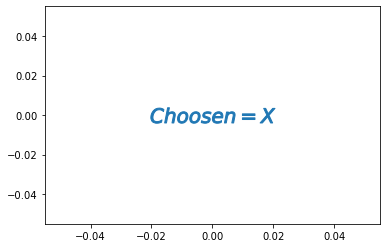

In [89]:
plt.plot([0], [0], marker="$Choosen = X$", label="month_end", markersize = 125)

In [90]:
CAT_FIELDS

['k_symbol_num', 'operation_num', 'type_num']

## Generate example

In [91]:
!pwd

/Users/kylenickerson/Desktop/verafin_proj_big/post_ecml/banksformer_v2b-cleanup


********** Generating element 1 of 20 **********
**Generating k_symbol


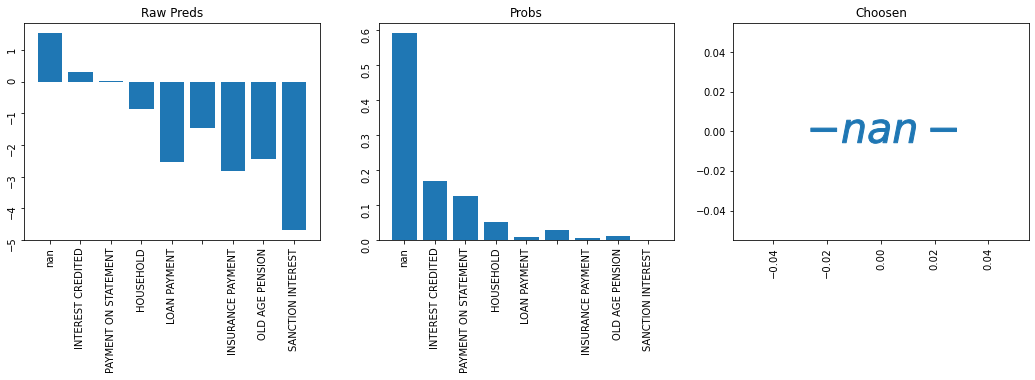

**Generating operation


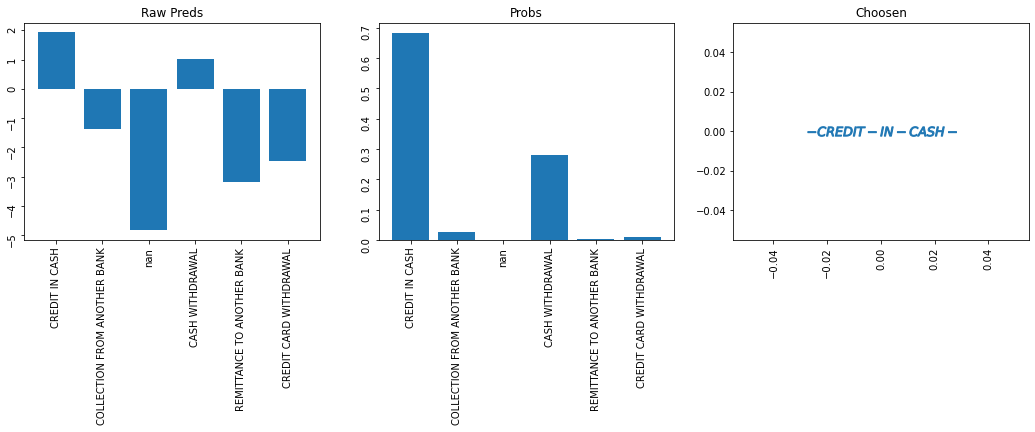

**Generating type


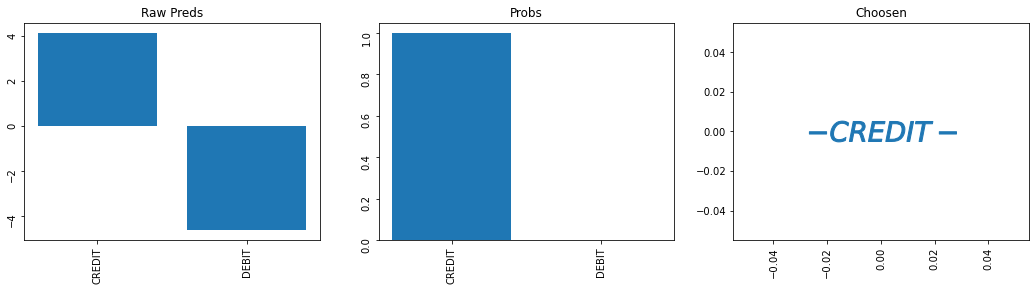

Amount. Unscaled mean = 3.29, sd = 0.00
Sampled value: 4.12
Unscaled value: 23707.68



*** Generating next date. Current Date is: 1993-01-01 0




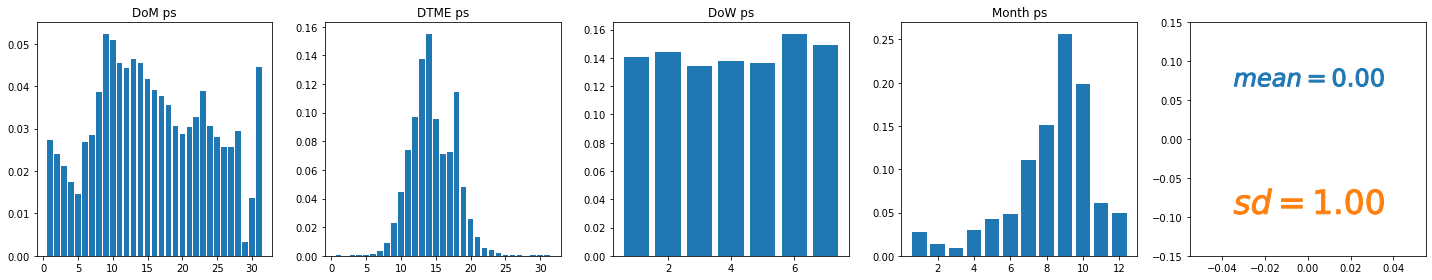

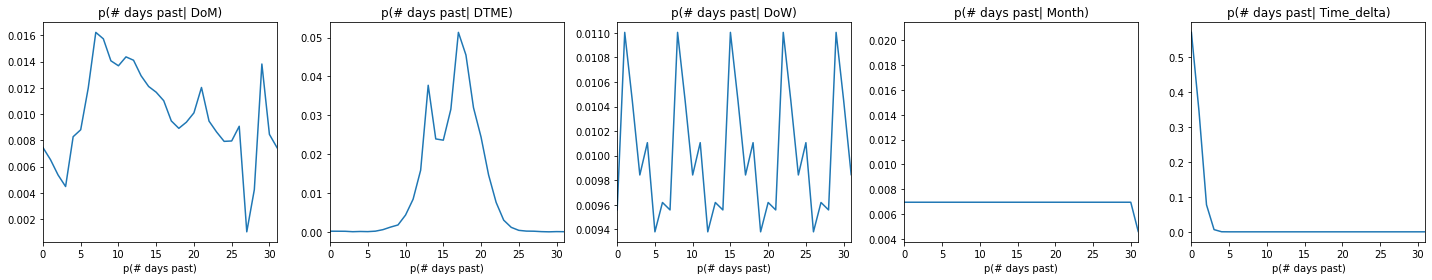

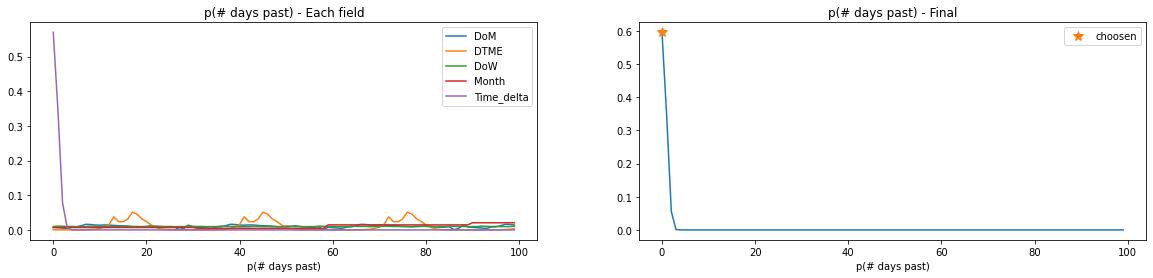





********** Generating element 2 of 20 **********
**Generating k_symbol


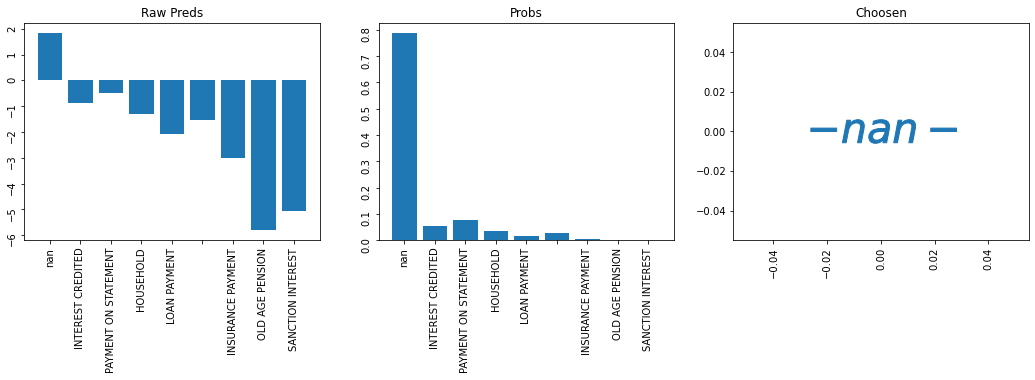

**Generating operation


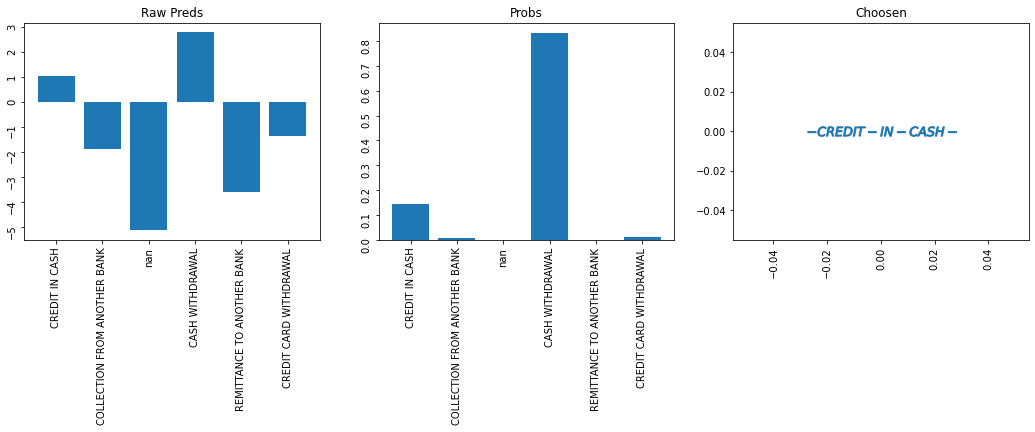

**Generating type


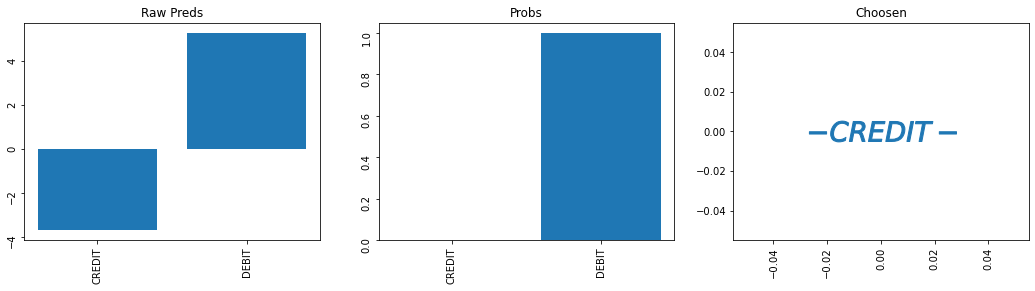

Amount. Unscaled mean = 3.72, sd = 0.00
Sampled value: 3.03
Unscaled value: 1667.66



*** Generating next date. Current Date is: 1993-01-01 0




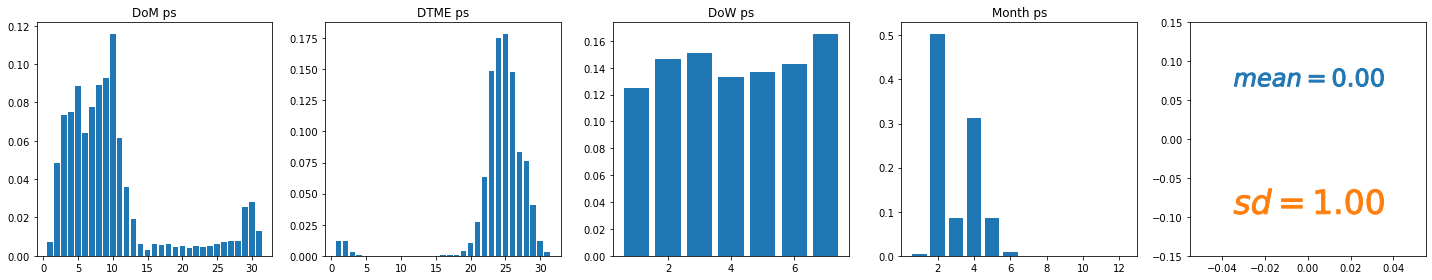

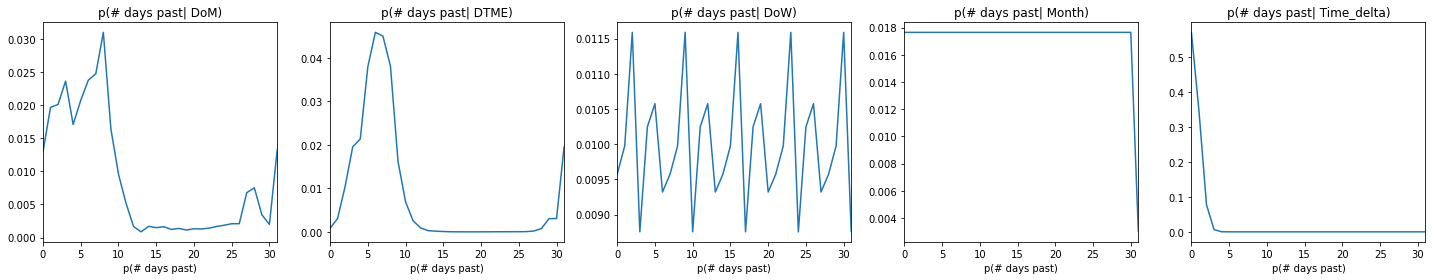

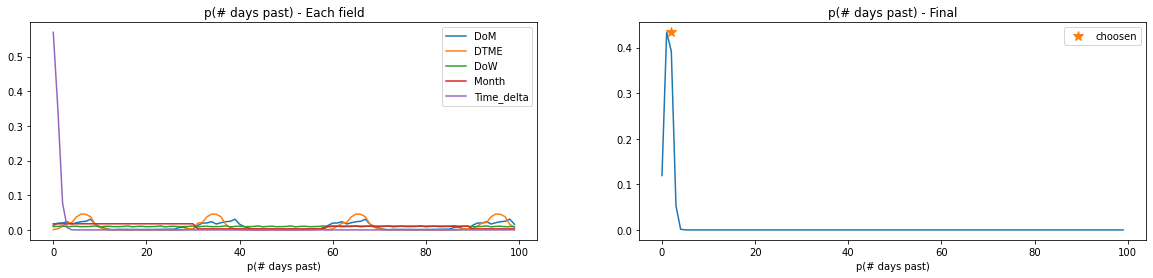





********** Generating element 3 of 20 **********
**Generating k_symbol


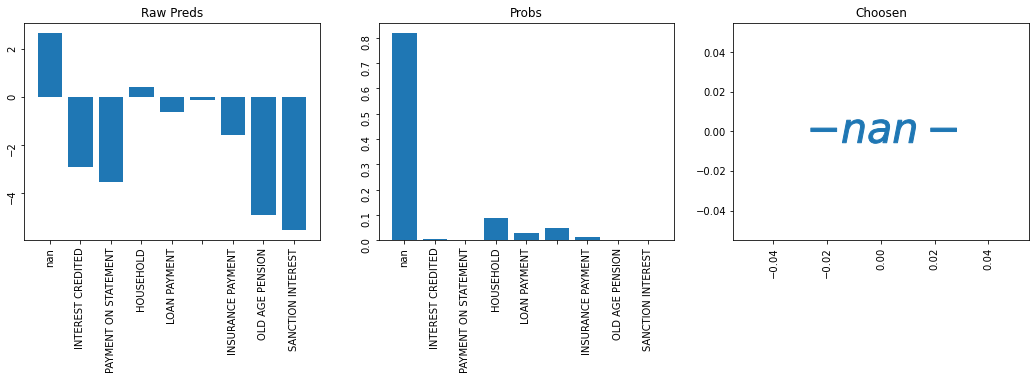

**Generating operation


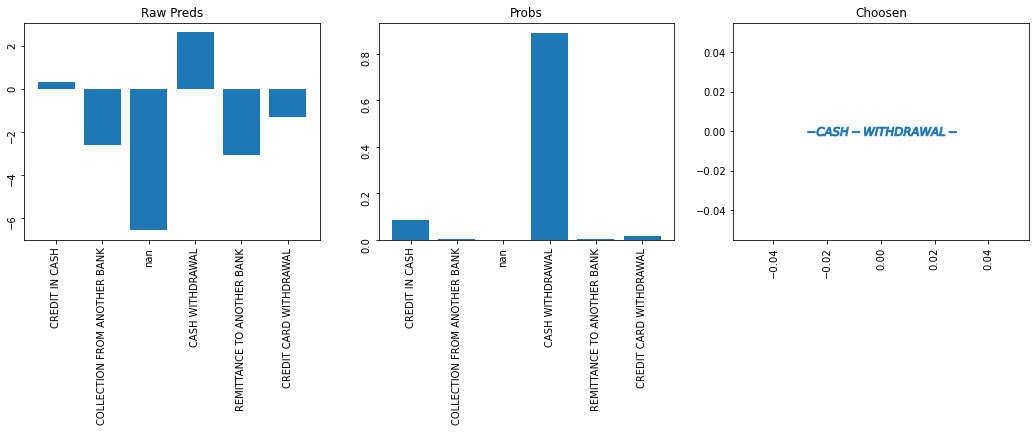

**Generating type


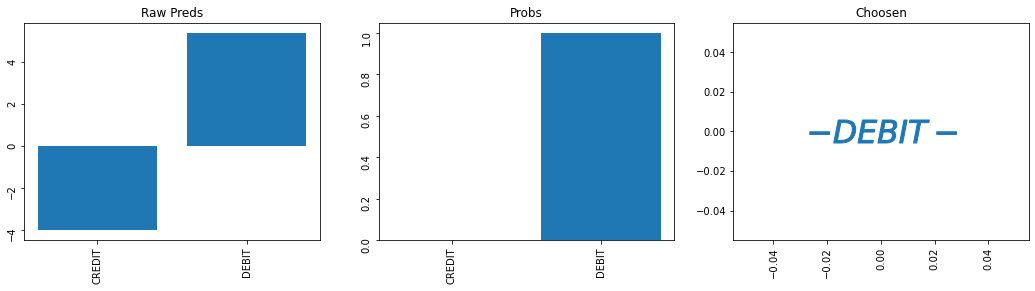

Amount. Unscaled mean = 3.55, sd = 0.00
Sampled value: 5.64
Unscaled value: 975599.75



*** Generating next date. Current Date is: 1993-01-03 0




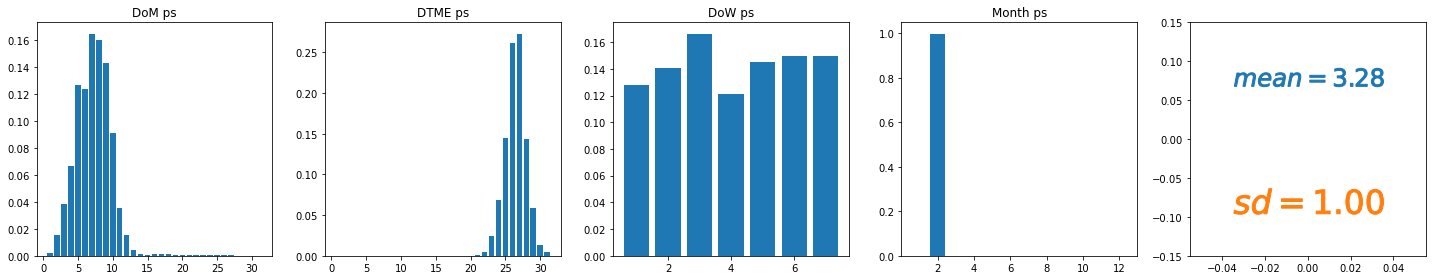

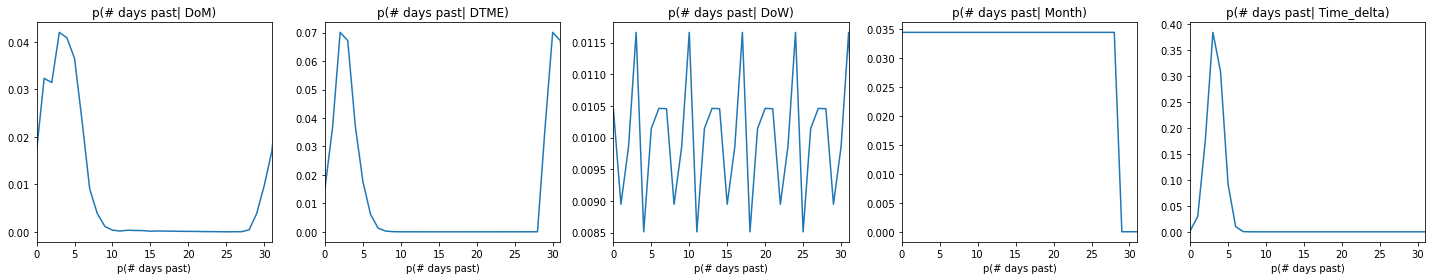

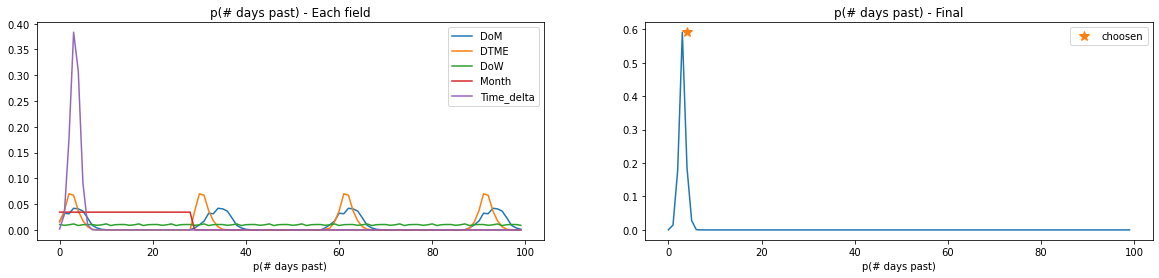





********** Generating element 4 of 20 **********
**Generating k_symbol


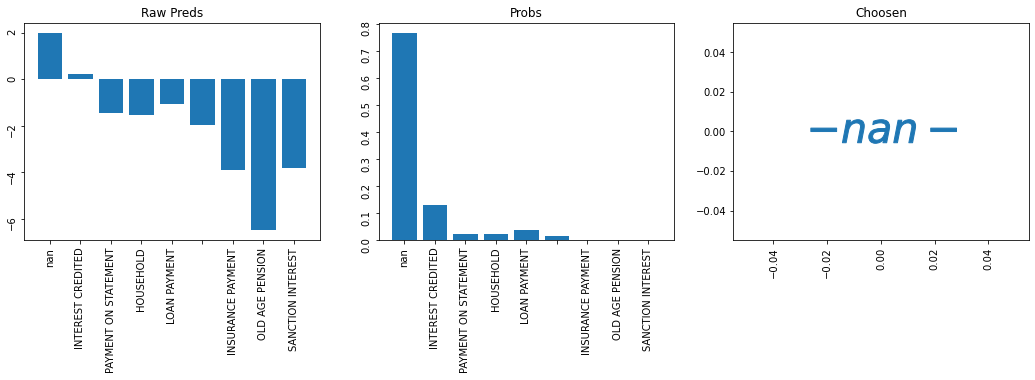

**Generating operation


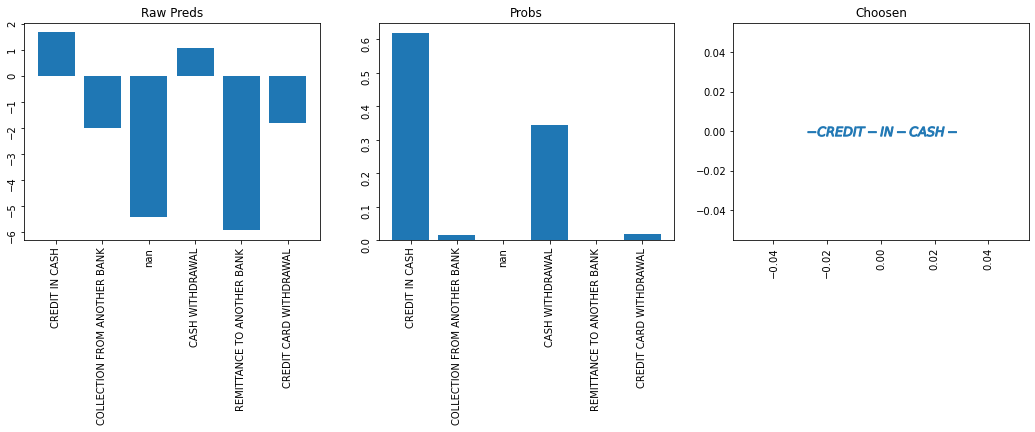

**Generating type


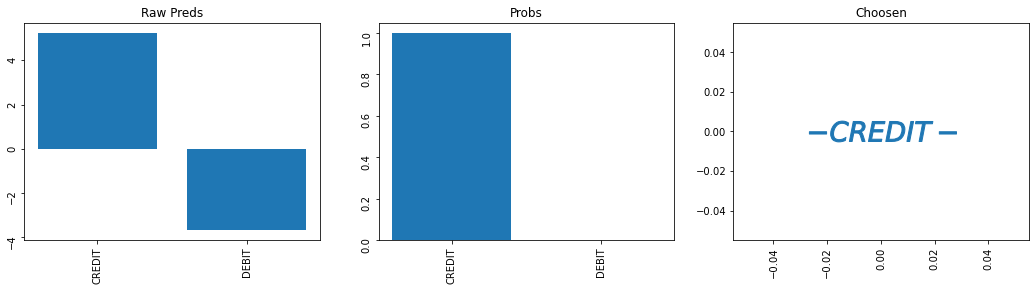

Amount. Unscaled mean = 3.96, sd = 0.00
Sampled value: 5.32
Unscaled value: 450923.91



*** Generating next date. Current Date is: 1993-01-07 0




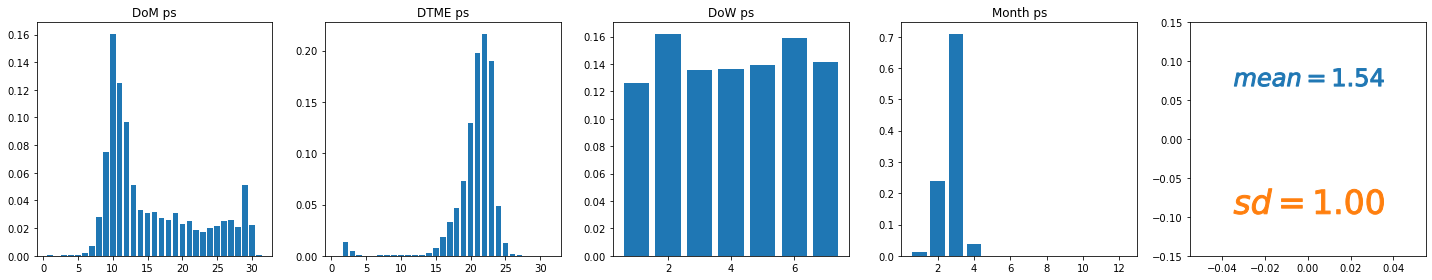

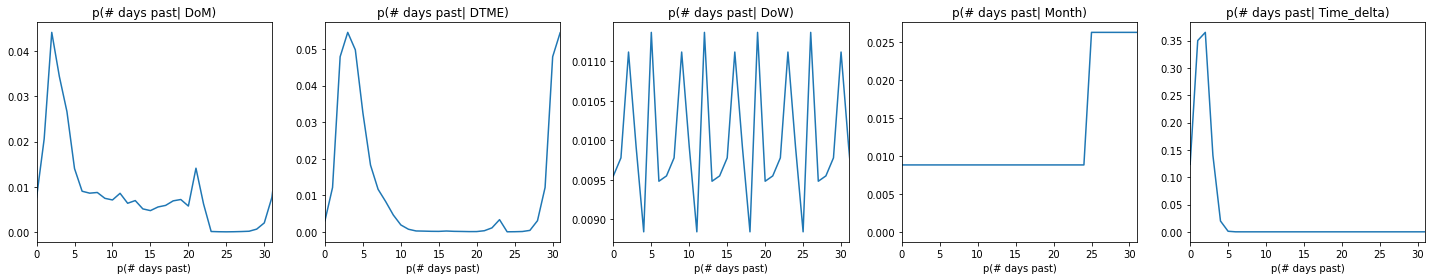

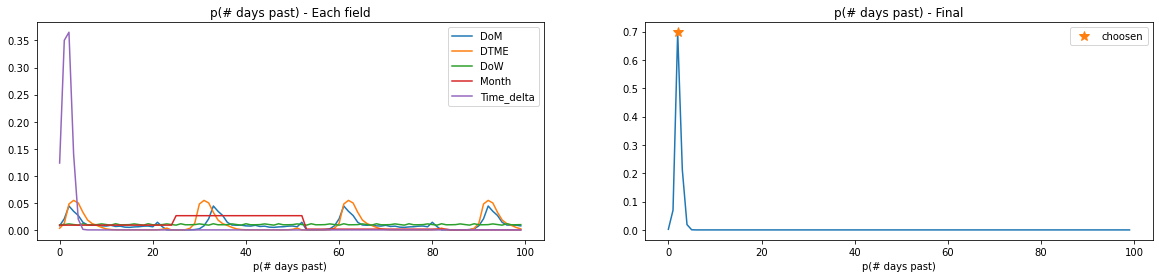





********** Generating element 5 of 20 **********
**Generating k_symbol


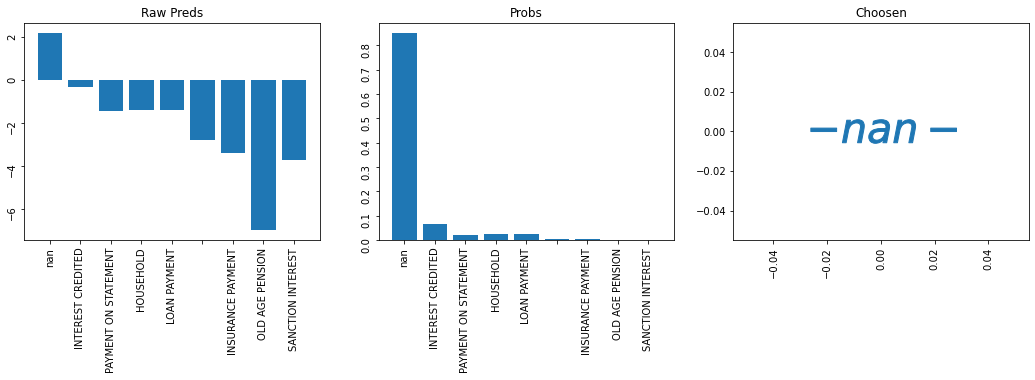

**Generating operation


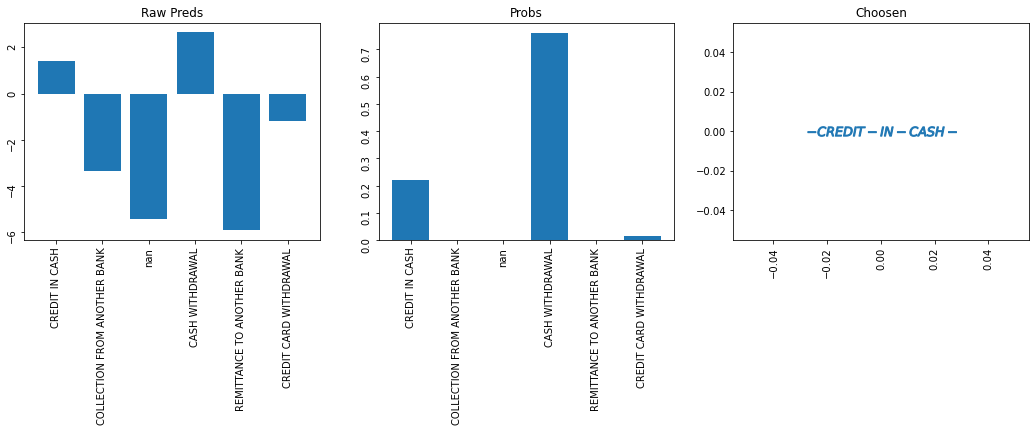

**Generating type


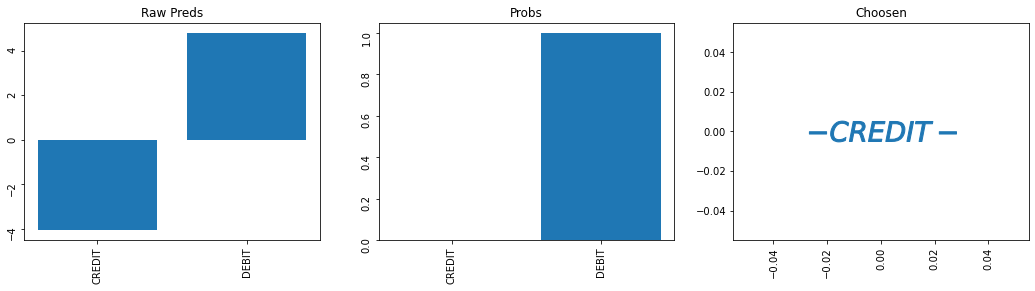

Amount. Unscaled mean = 3.92, sd = 0.00
Sampled value: 3.28
Unscaled value: 3020.11



*** Generating next date. Current Date is: 1993-01-09 0




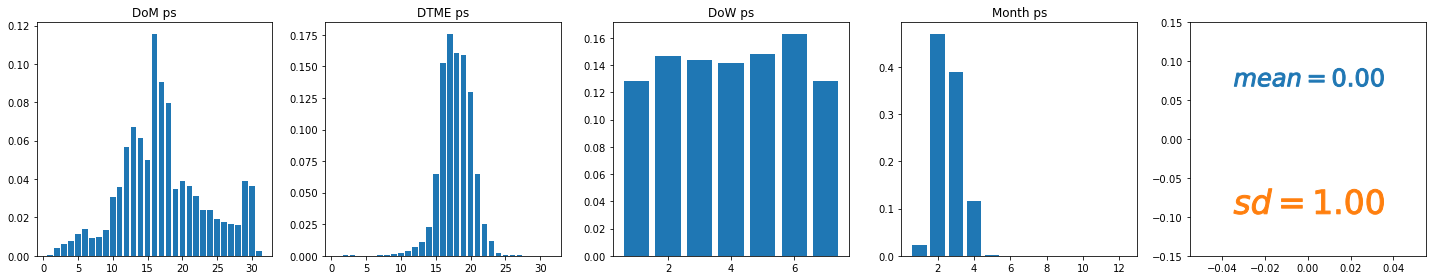

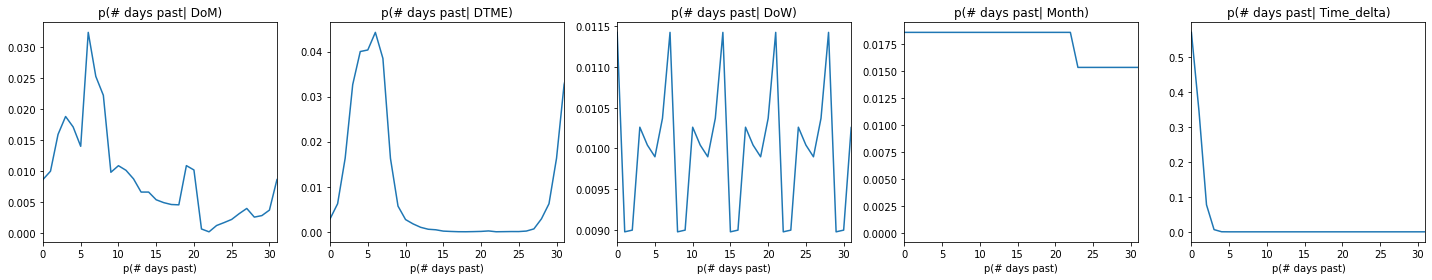

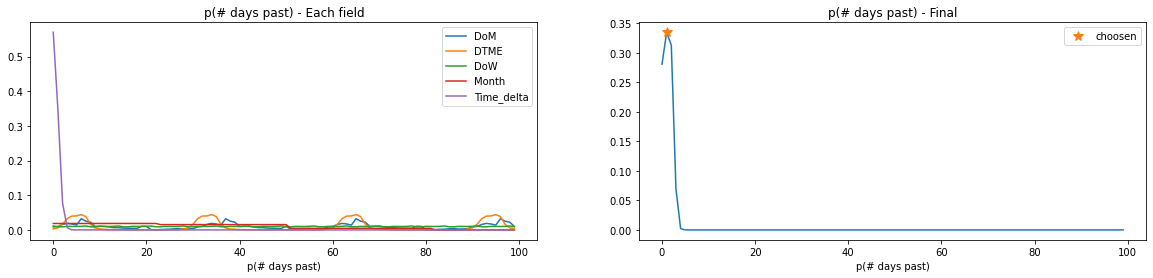





********** Generating element 6 of 20 **********
**Generating k_symbol


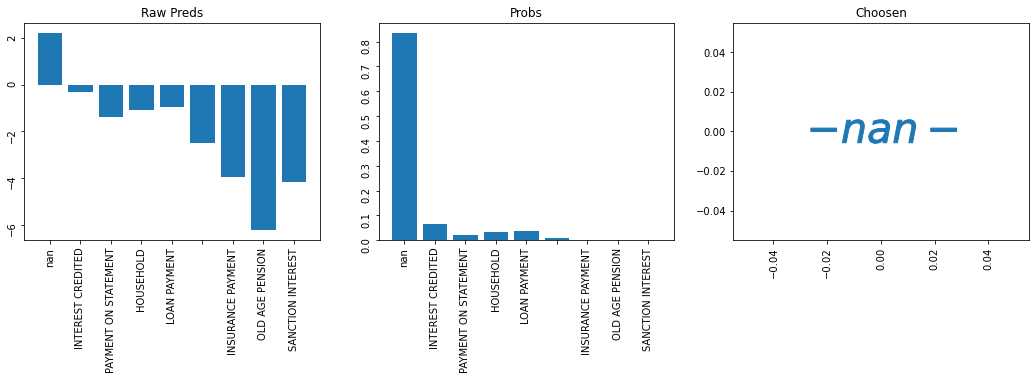

**Generating operation


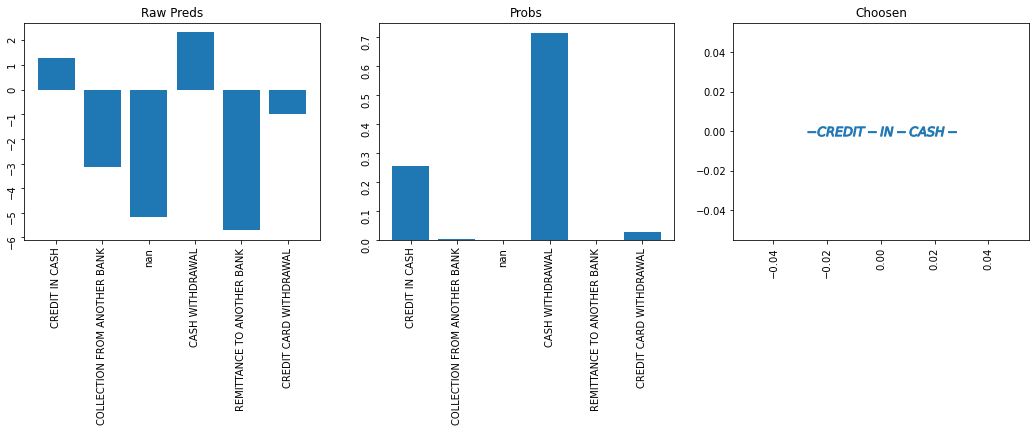

**Generating type


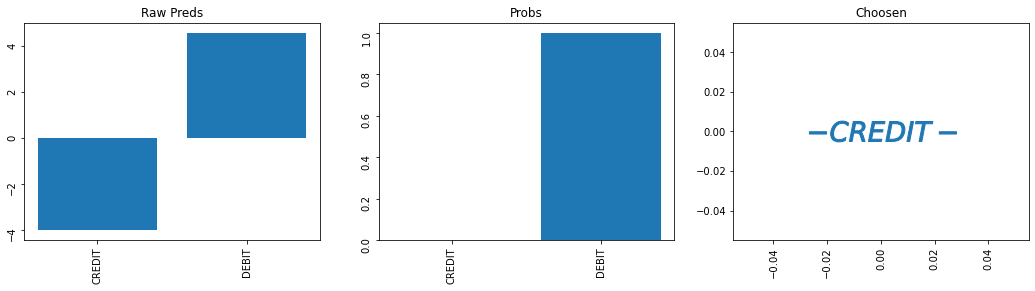

Amount. Unscaled mean = 3.72, sd = 0.00
Sampled value: 5.45
Unscaled value: 622397.19



*** Generating next date. Current Date is: 1993-01-10 0




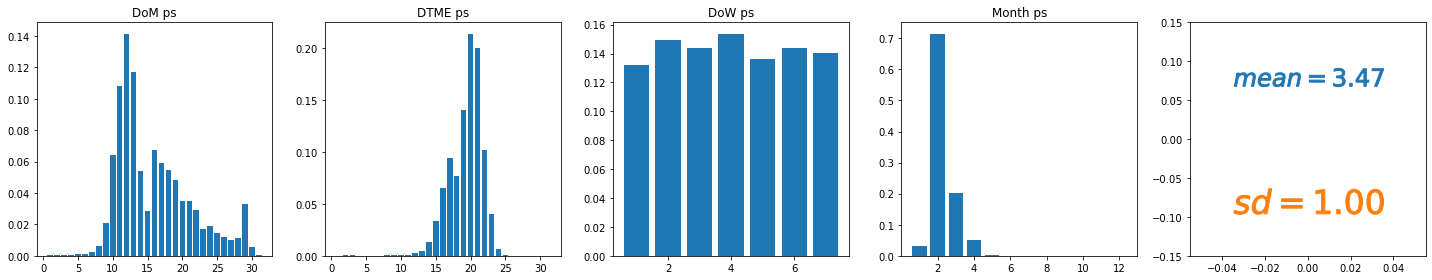

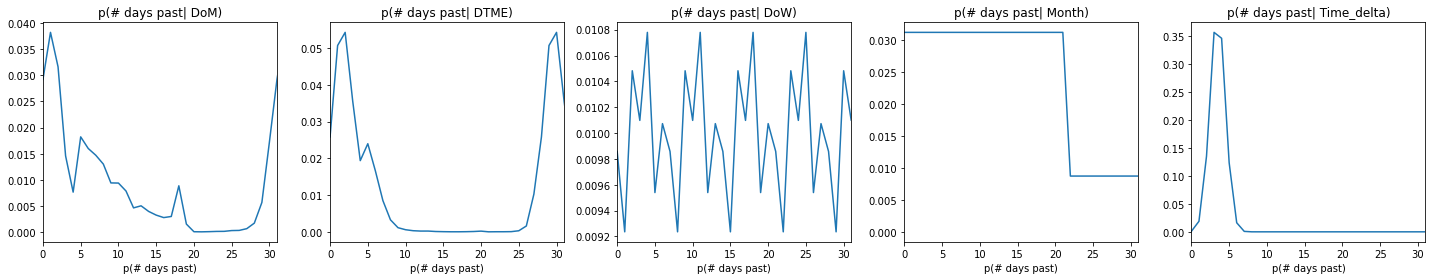

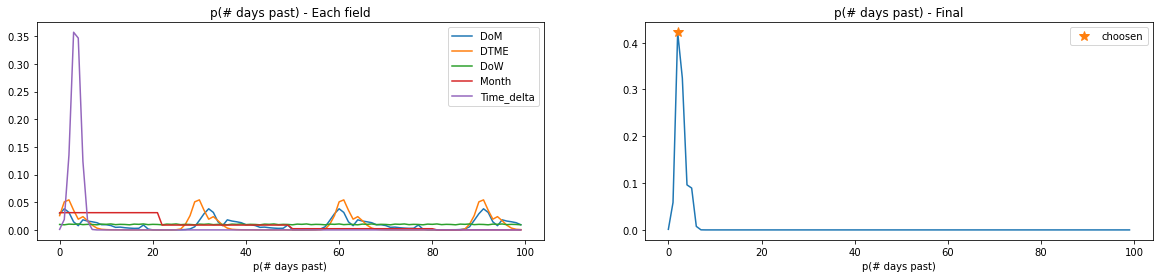





********** Generating element 7 of 20 **********
**Generating k_symbol


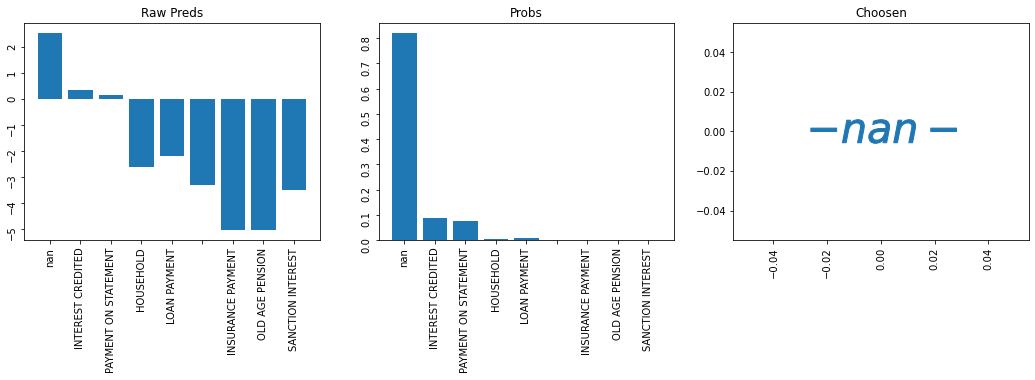

**Generating operation


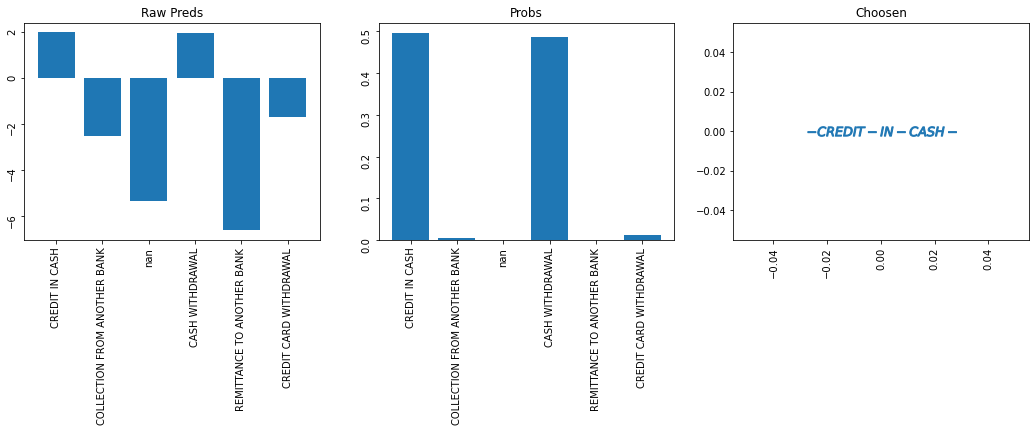

**Generating type


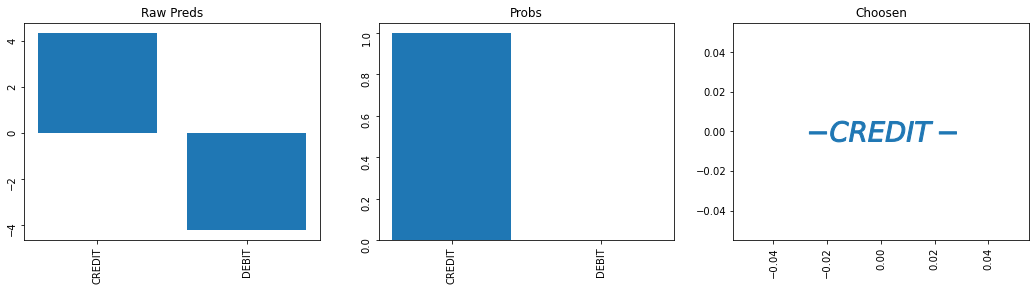

Amount. Unscaled mean = 4.09, sd = 0.00
Sampled value: 3.52
Unscaled value: 5546.42



*** Generating next date. Current Date is: 1993-01-12 0




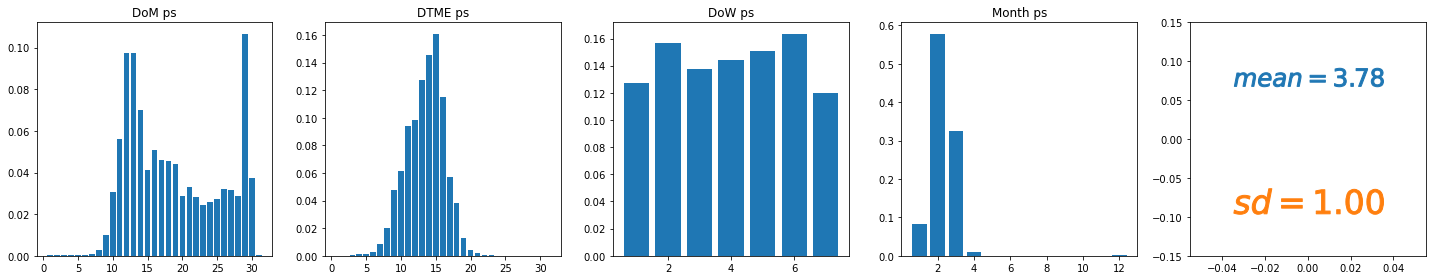

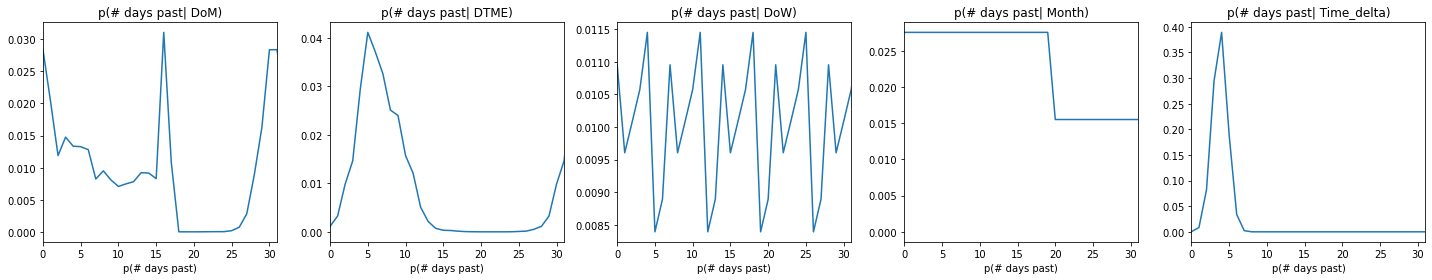

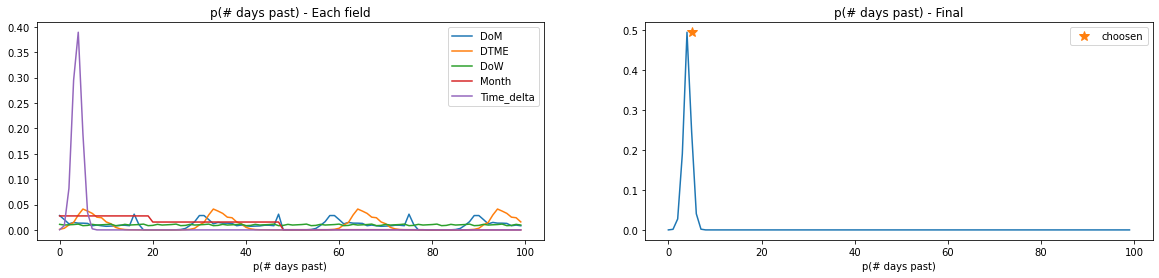





********** Generating element 8 of 20 **********
**Generating k_symbol


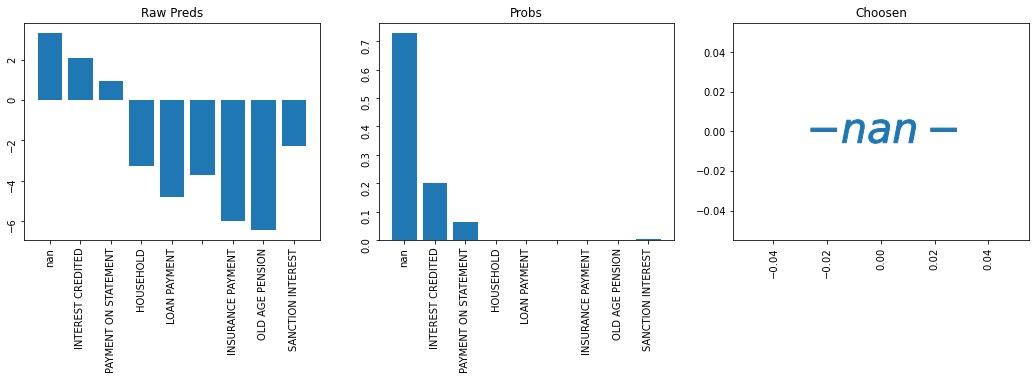

**Generating operation


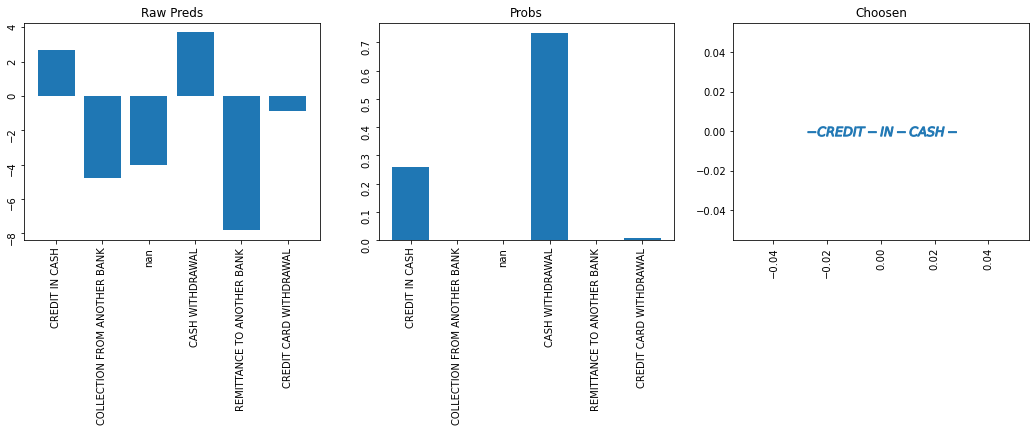

**Generating type


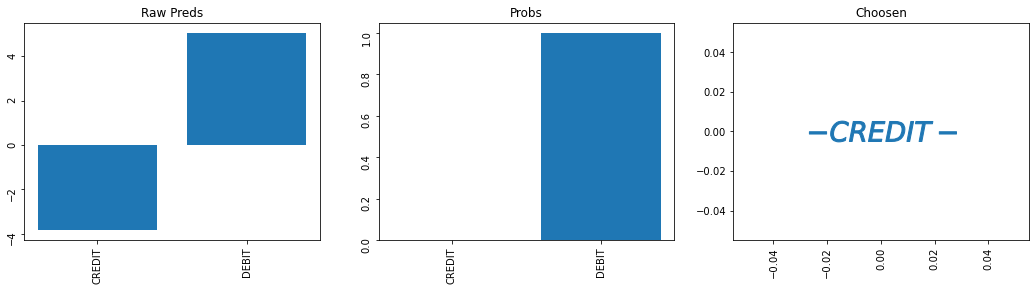

Amount. Unscaled mean = 3.76, sd = 0.00
Sampled value: 4.69
Unscaled value: 97333.96



*** Generating next date. Current Date is: 1993-01-17 0




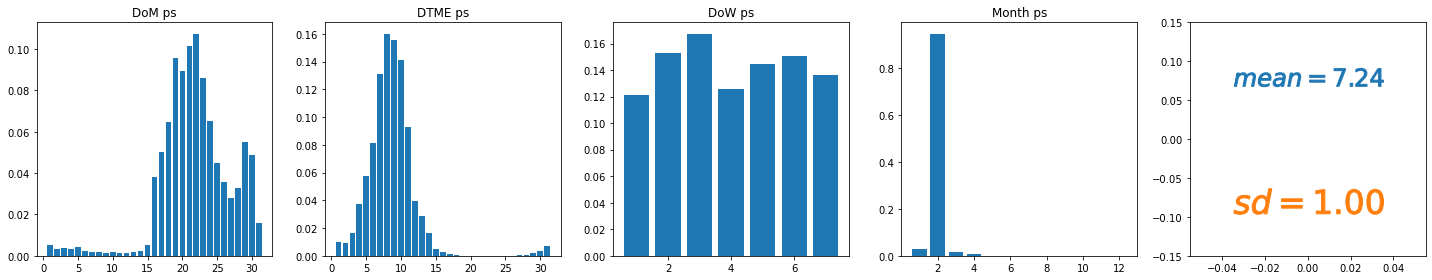

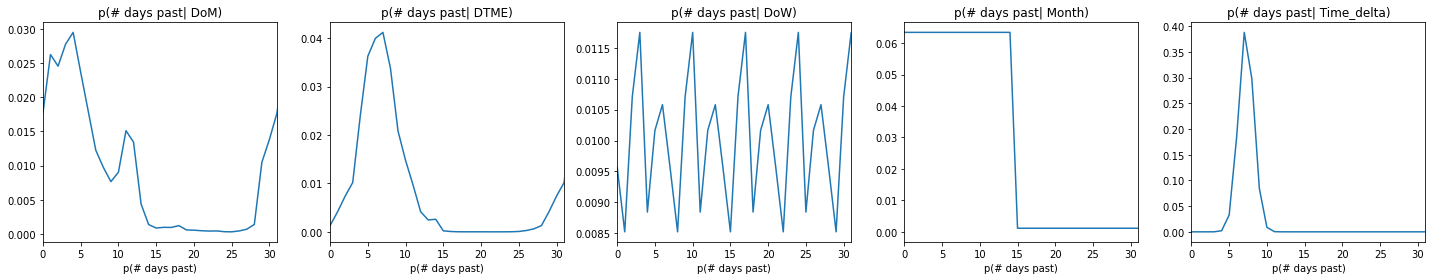

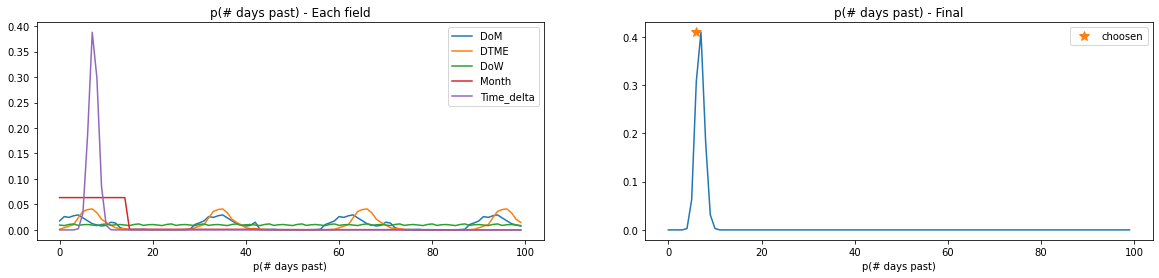





********** Generating element 9 of 20 **********
**Generating k_symbol


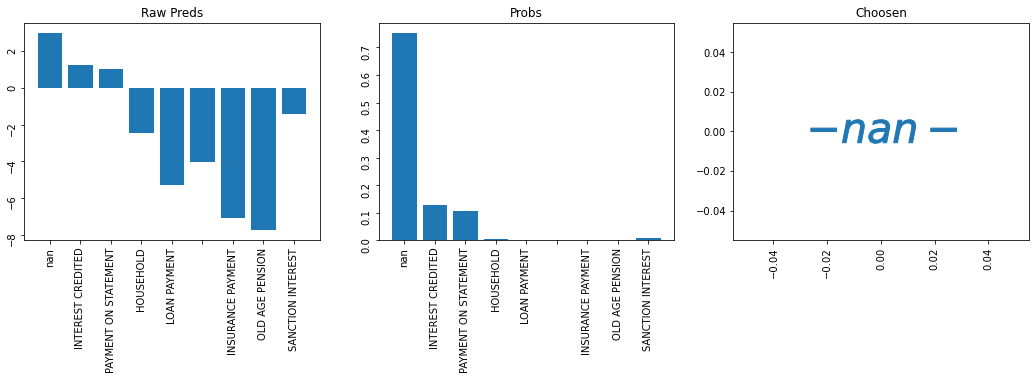

**Generating operation


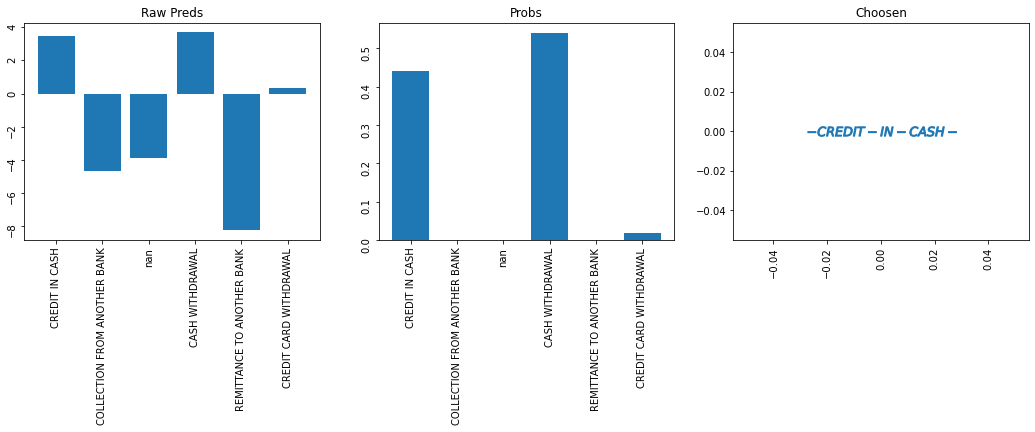

**Generating type


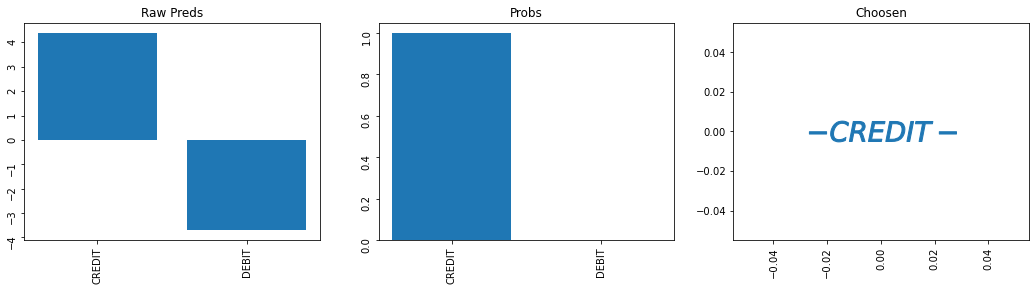

Amount. Unscaled mean = 4.04, sd = 0.00
Sampled value: 4.64
Unscaled value: 86026.36



*** Generating next date. Current Date is: 1993-01-23 0




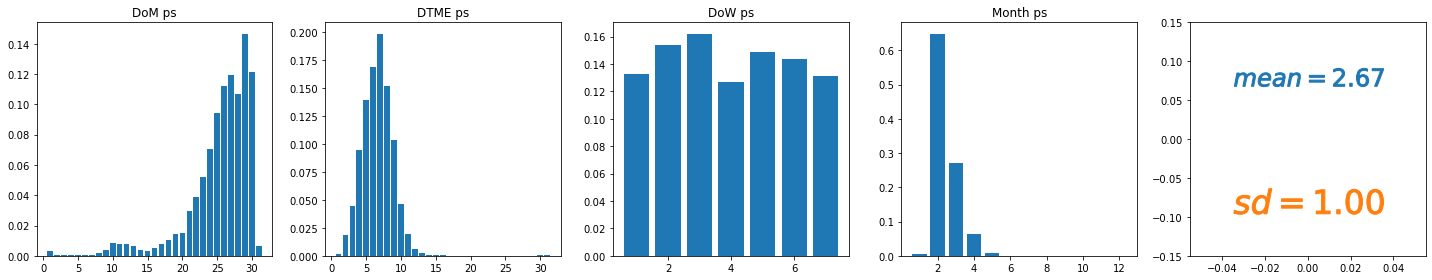

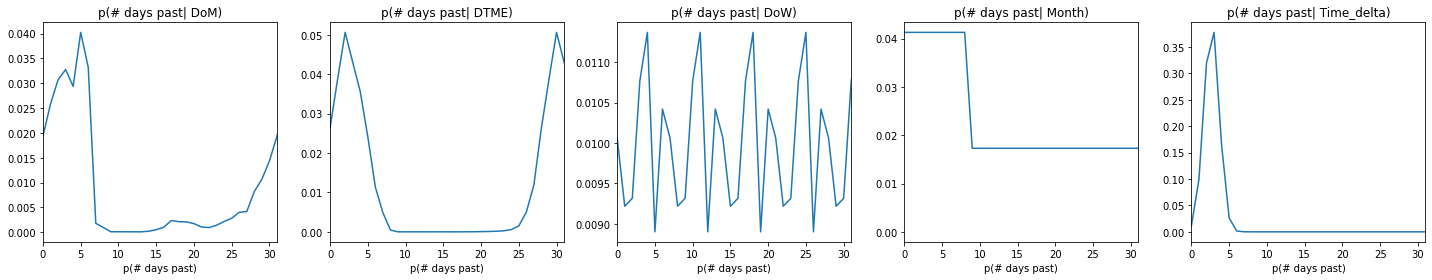

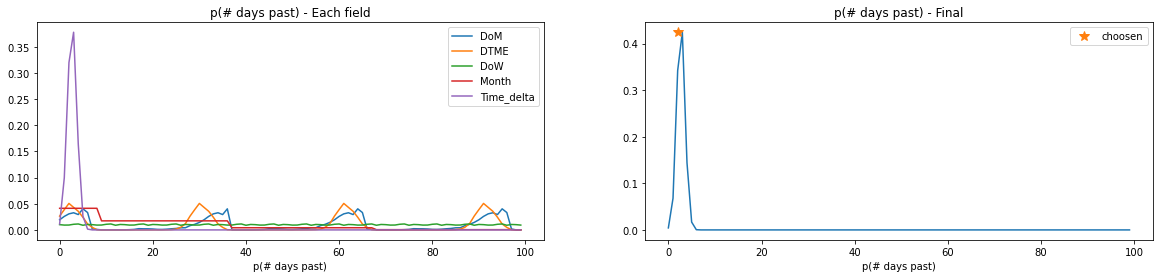





********** Generating element 10 of 20 **********
**Generating k_symbol


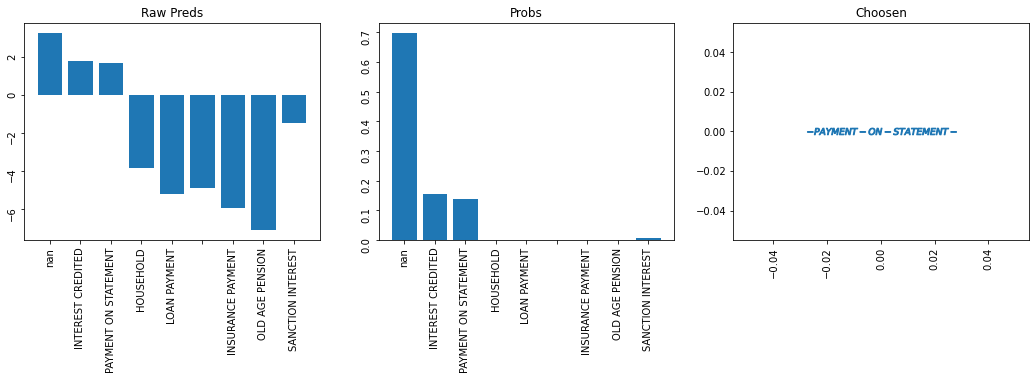

**Generating operation


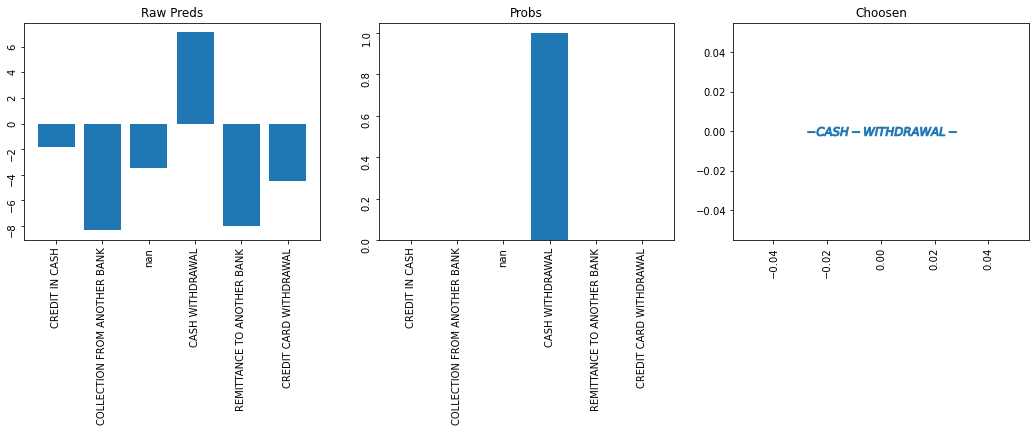

**Generating type


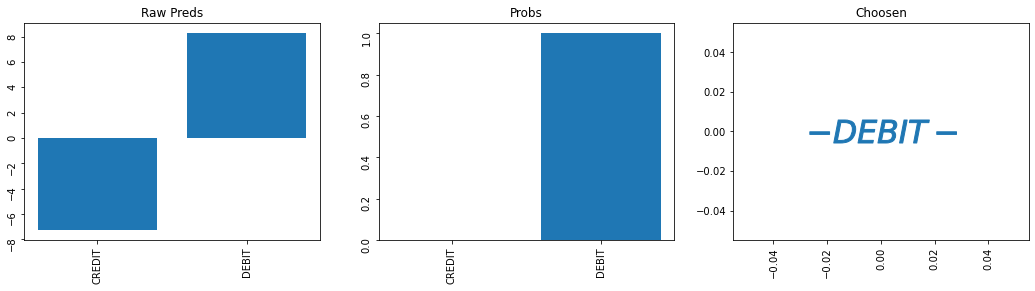

Amount. Unscaled mean = 1.58, sd = 0.00
Sampled value: 1.55
Unscaled value: 43.37



*** Generating next date. Current Date is: 1993-01-25 0




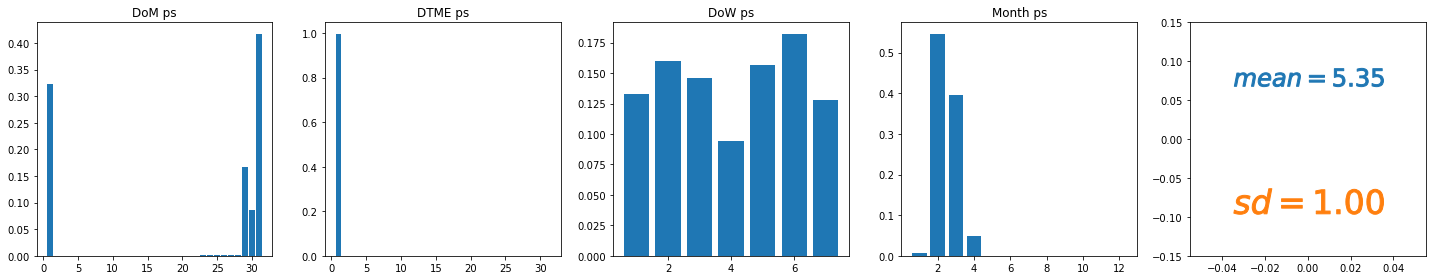

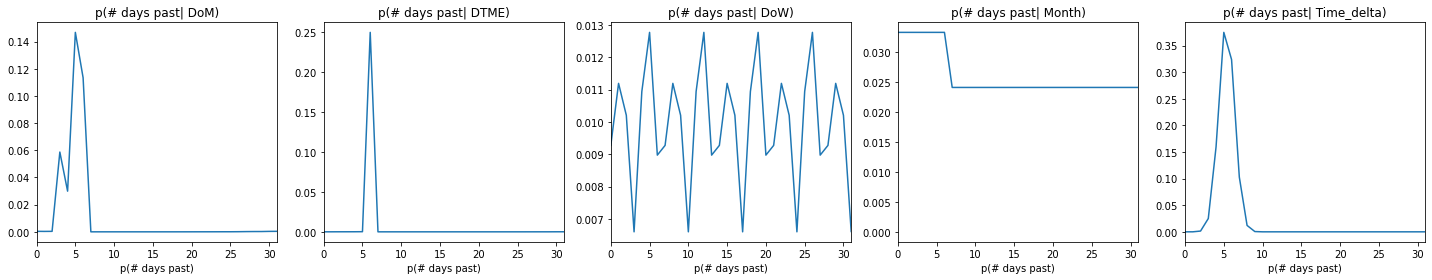

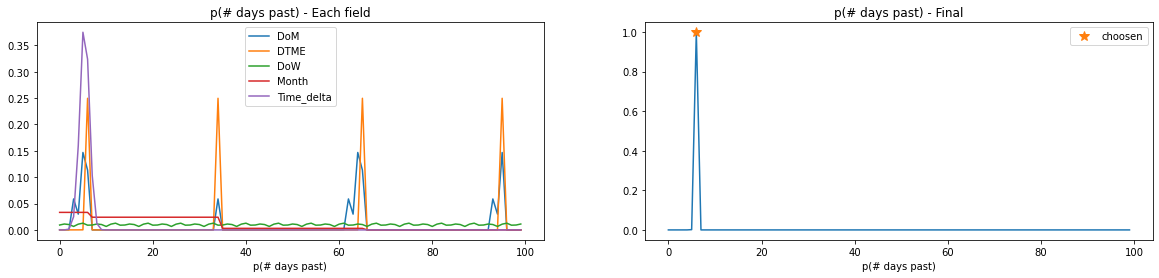





********** Generating element 11 of 20 **********
**Generating k_symbol


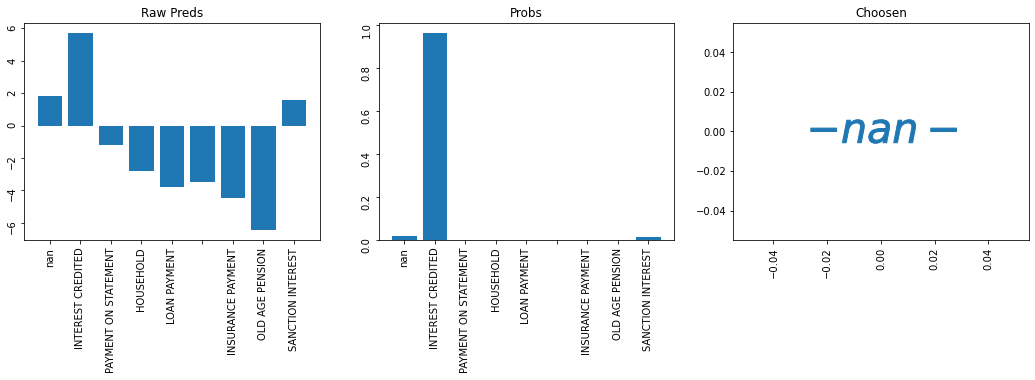

**Generating operation


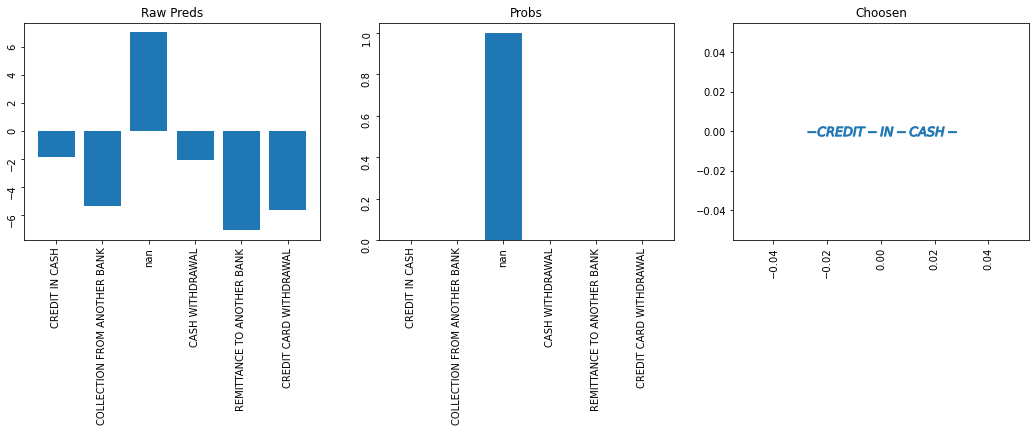

**Generating type


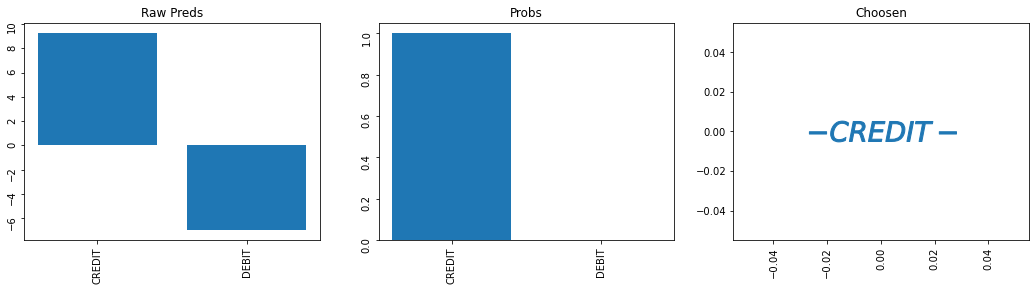

Amount. Unscaled mean = 2.17, sd = 0.00
Sampled value: 1.08
Unscaled value: 13.09



*** Generating next date. Current Date is: 1993-01-31 0




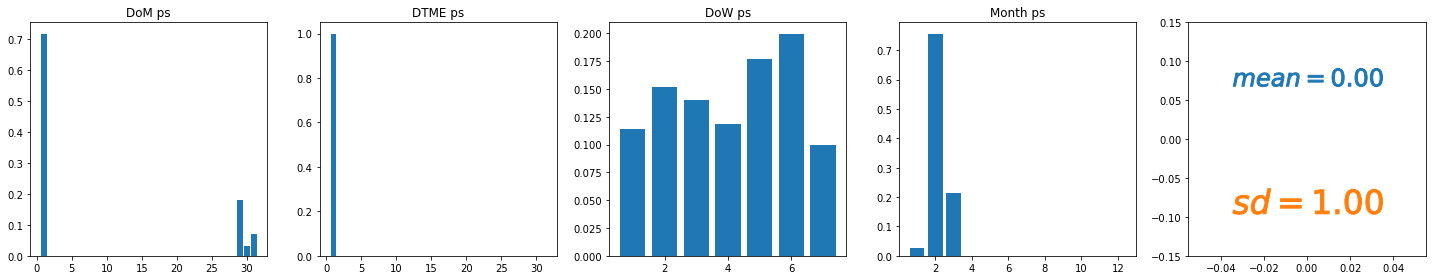

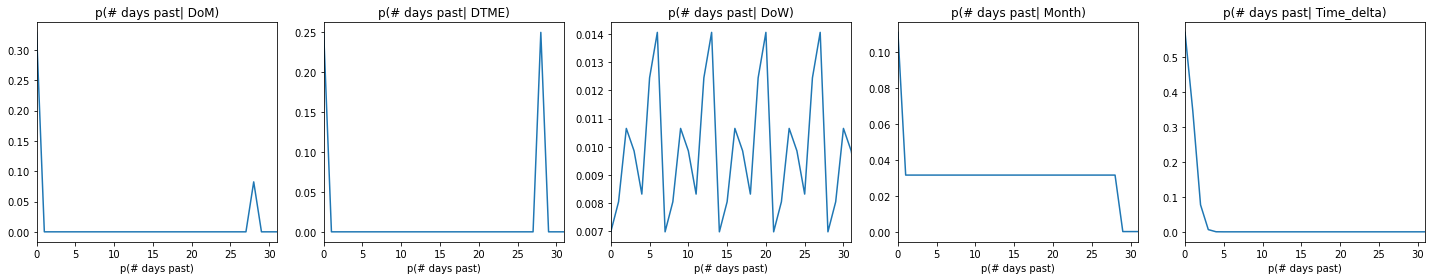

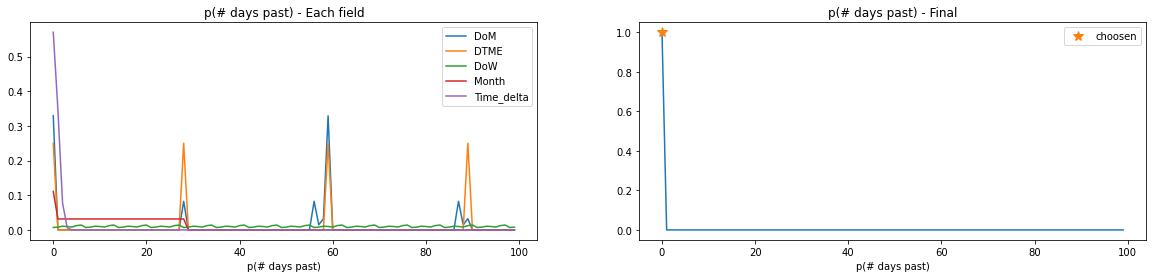





********** Generating element 12 of 20 **********
**Generating k_symbol


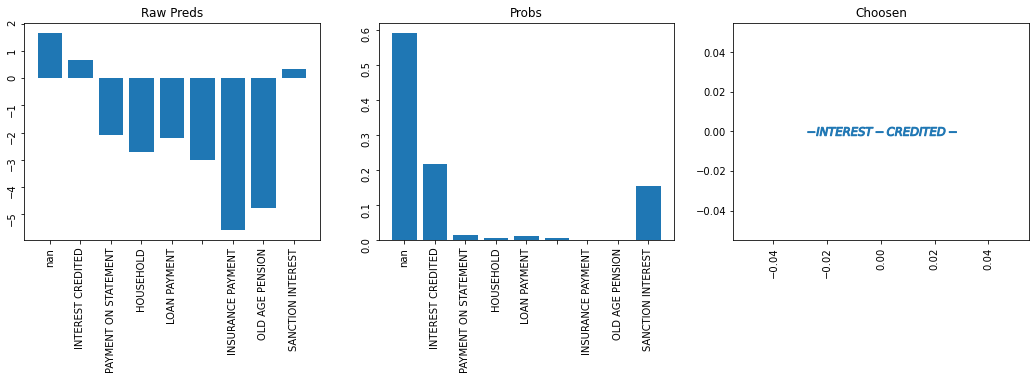

**Generating operation


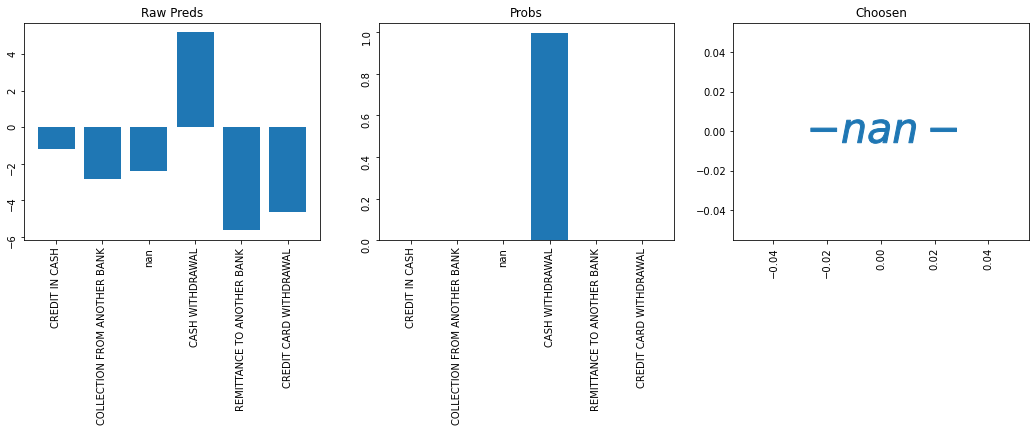

**Generating type


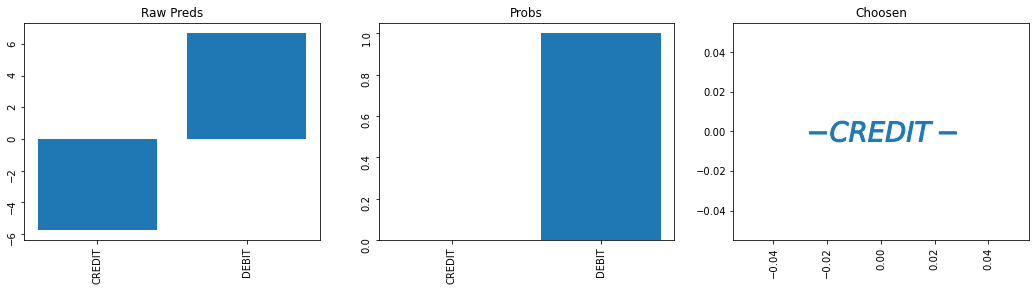

Amount. Unscaled mean = 1.28, sd = 0.00
Sampled value: 0.67
Unscaled value: 4.15



*** Generating next date. Current Date is: 1993-01-31 0




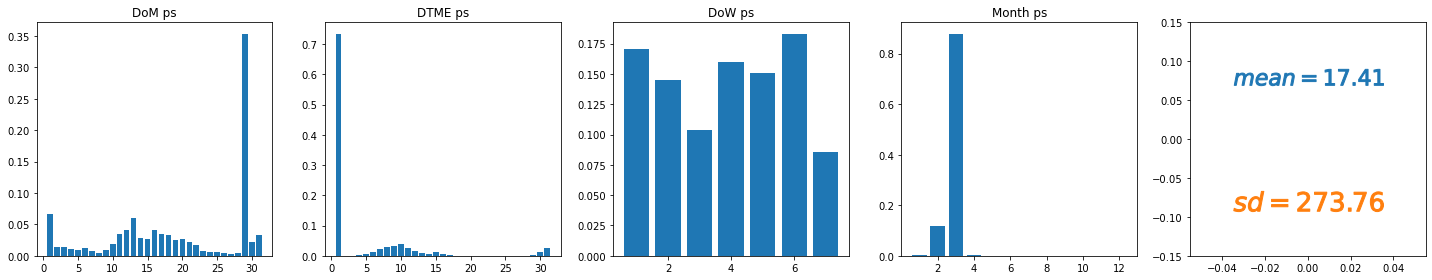

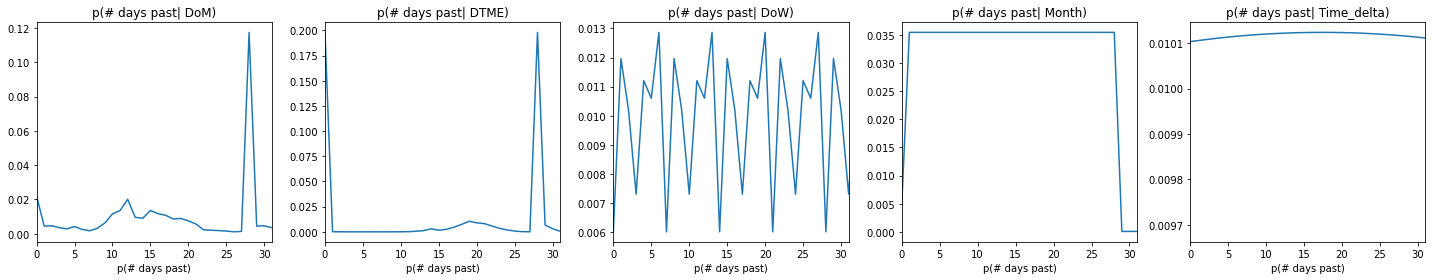

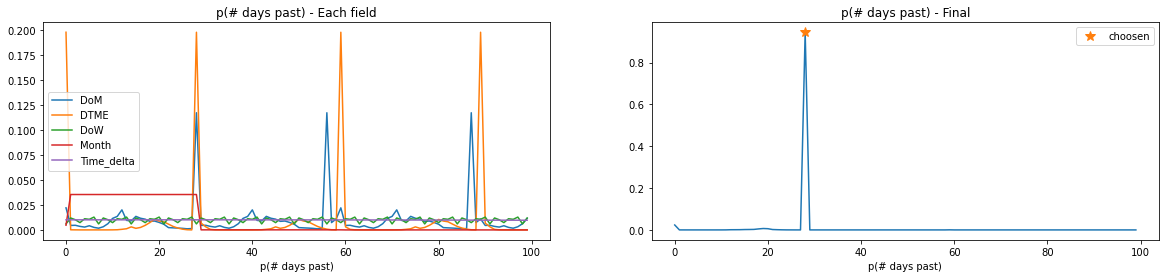





********** Generating element 13 of 20 **********
**Generating k_symbol


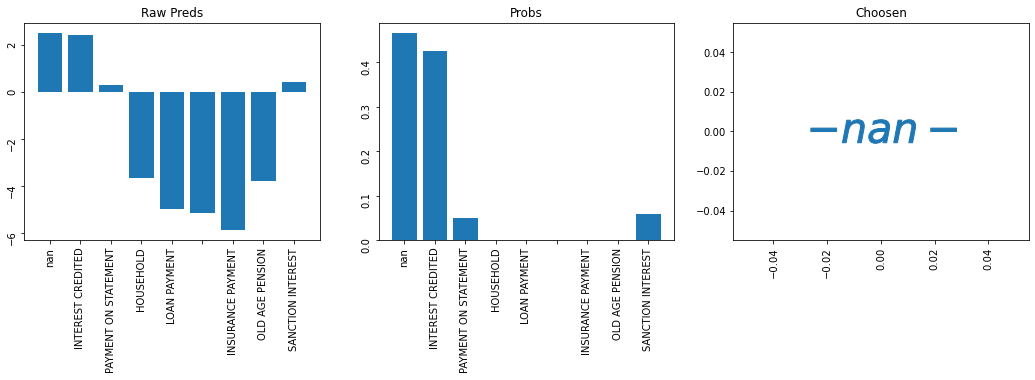

**Generating operation


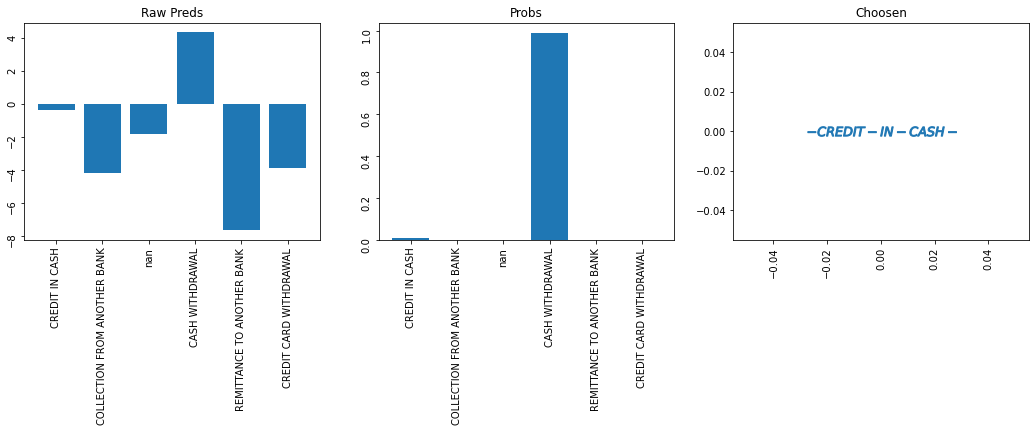

**Generating type


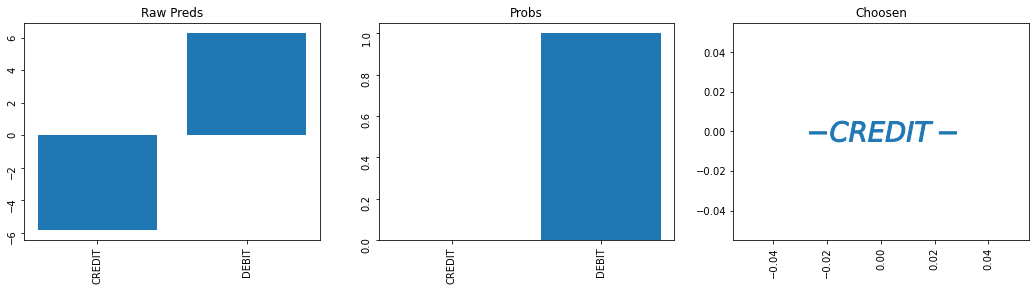

Amount. Unscaled mean = 0.98, sd = 0.00
Sampled value: 0.62
Unscaled value: 3.52



*** Generating next date. Current Date is: 1993-02-28 0




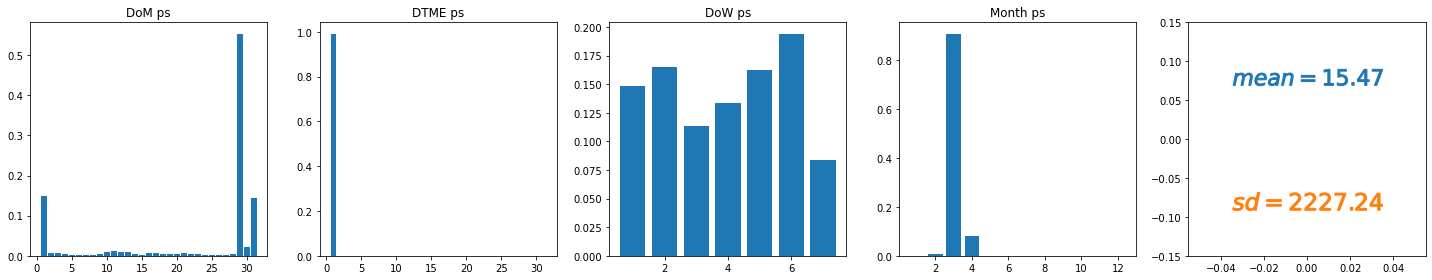

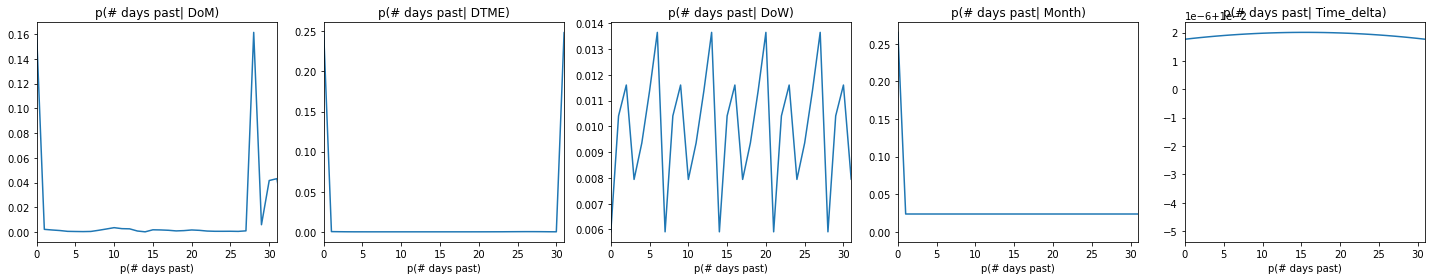

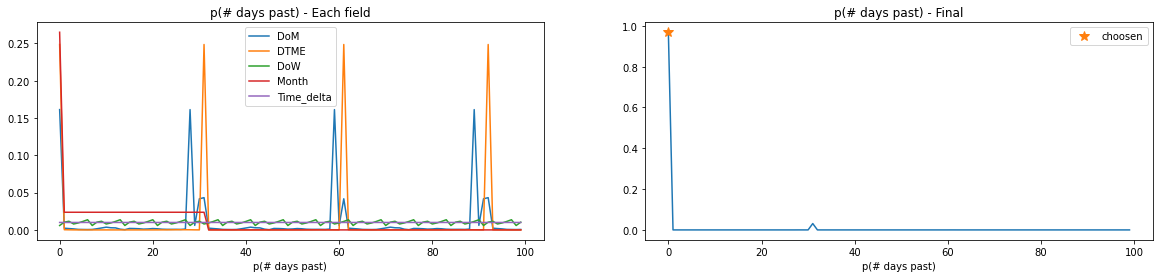





********** Generating element 14 of 20 **********
**Generating k_symbol


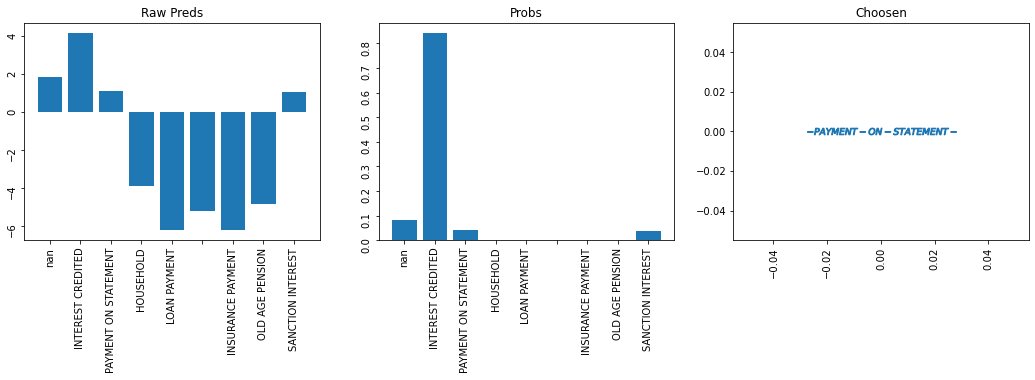

**Generating operation


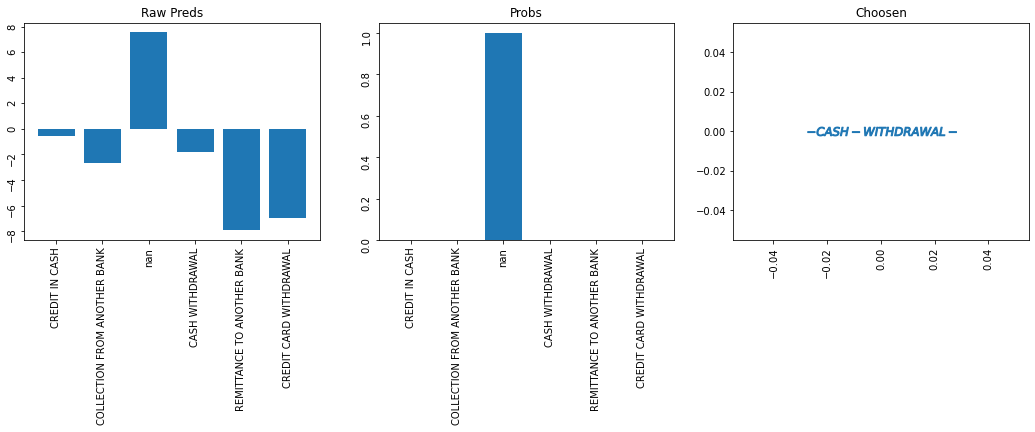

**Generating type


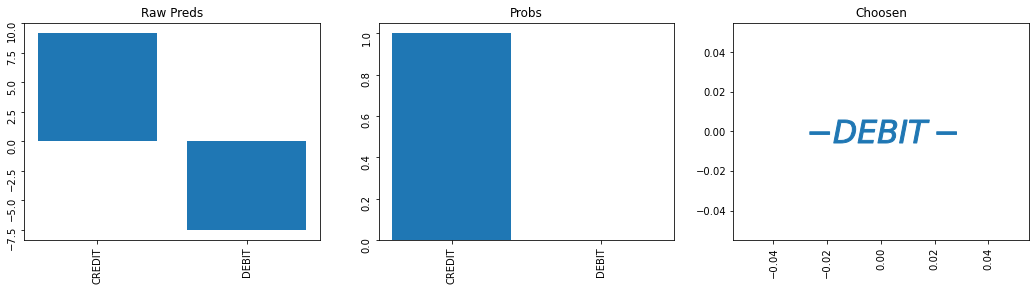

Amount. Unscaled mean = 1.69, sd = 0.00
Sampled value: 2.07
Unscaled value: 159.14



*** Generating next date. Current Date is: 1993-02-28 0




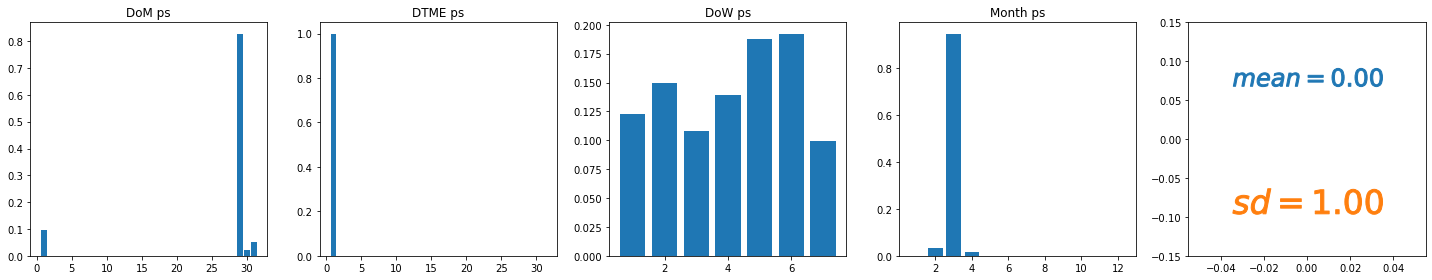

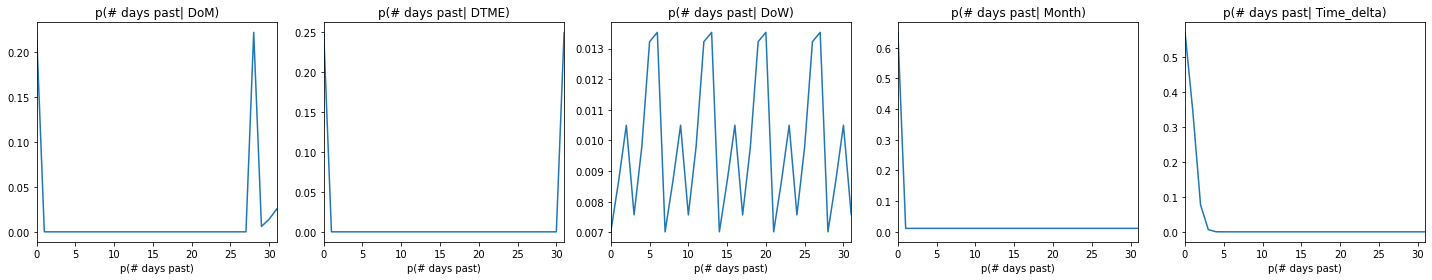

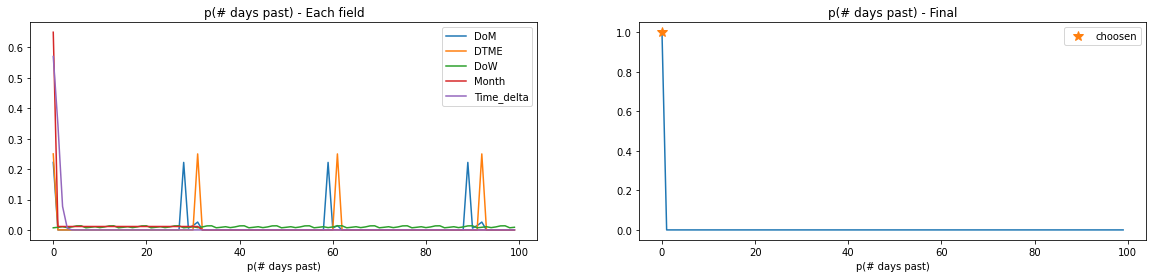





********** Generating element 15 of 20 **********
**Generating k_symbol


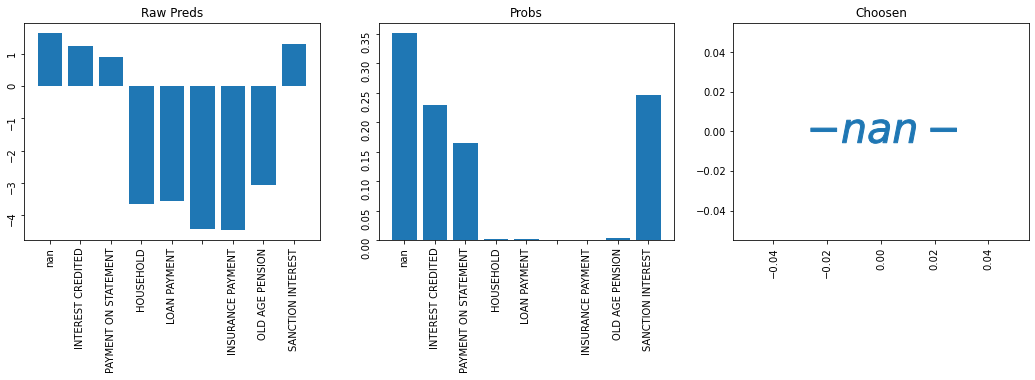

**Generating operation


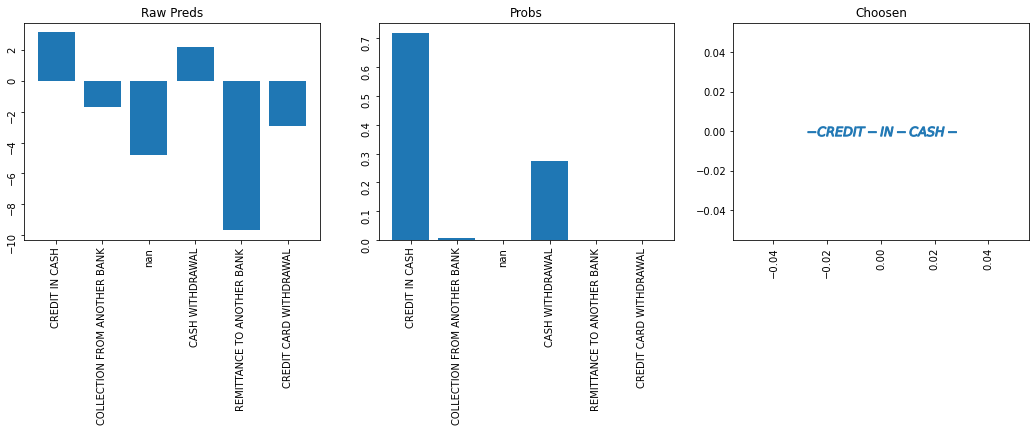

**Generating type


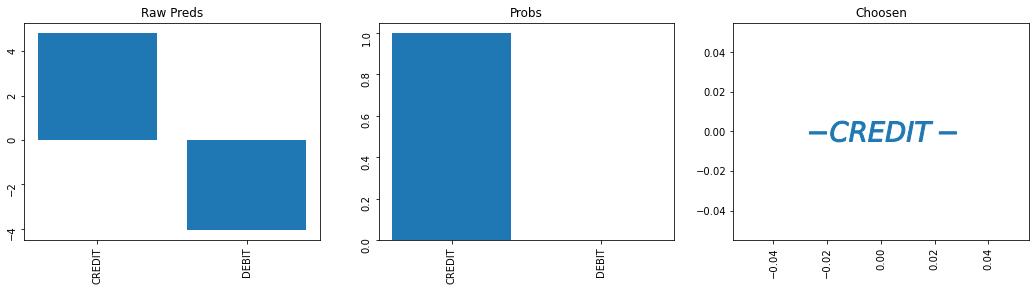

Amount. Unscaled mean = 3.72, sd = 0.00
Sampled value: 5.09
Unscaled value: 254909.27



*** Generating next date. Current Date is: 1993-02-28 0




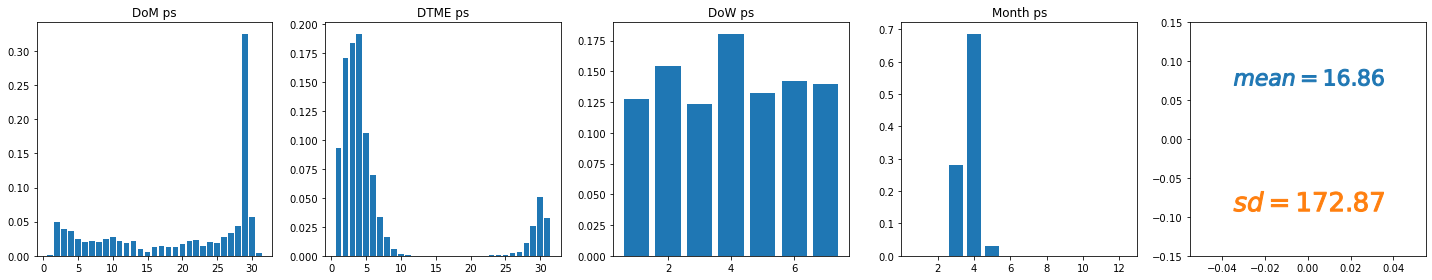

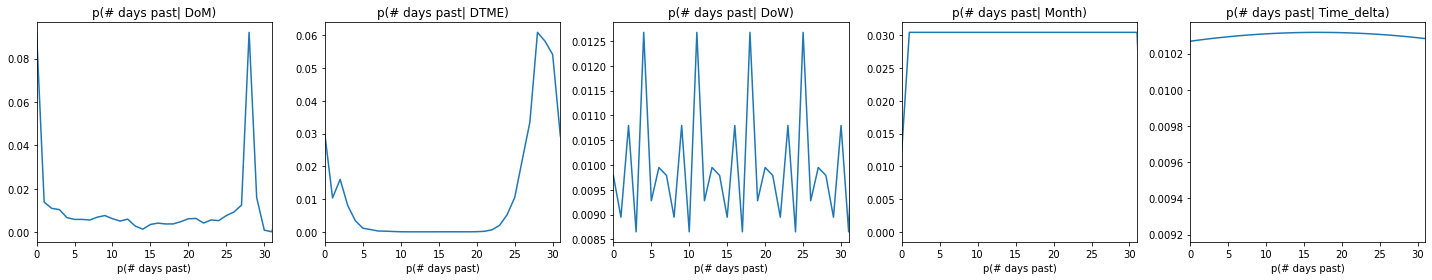

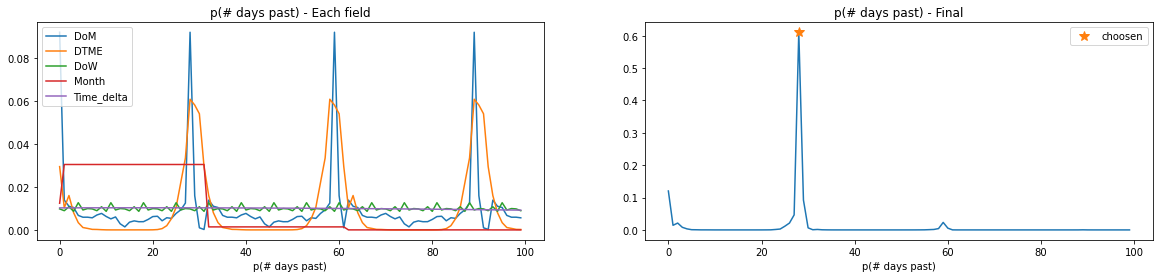





********** Generating element 16 of 20 **********
**Generating k_symbol


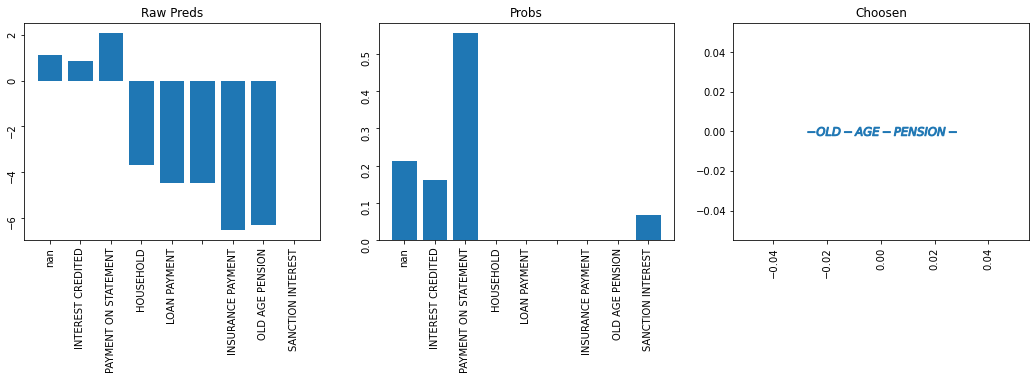

**Generating operation


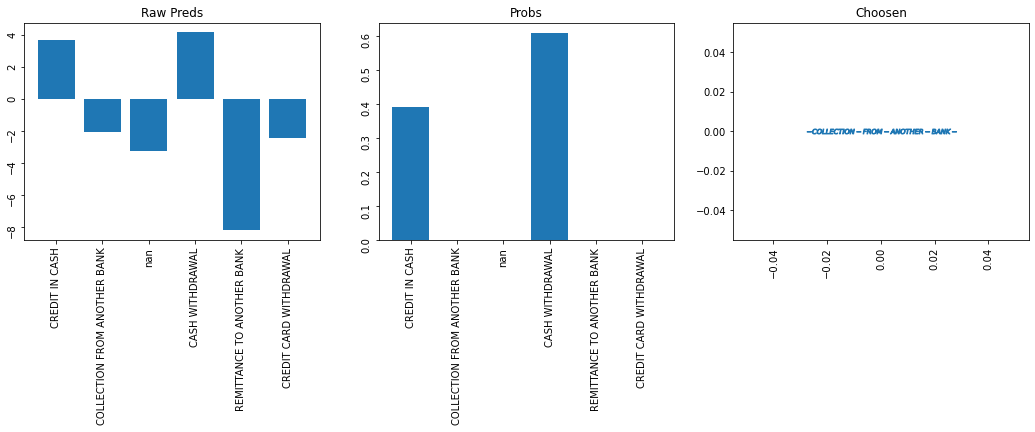

**Generating type


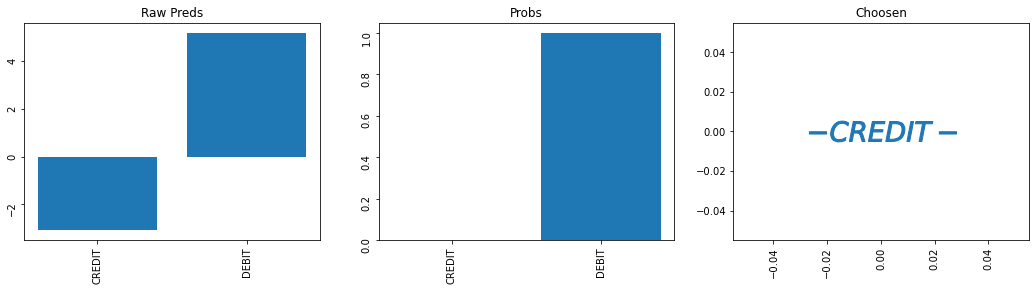

Amount. Unscaled mean = 3.55, sd = 0.00
Sampled value: 1.31
Unscaled value: 23.51



*** Generating next date. Current Date is: 1993-03-28 0




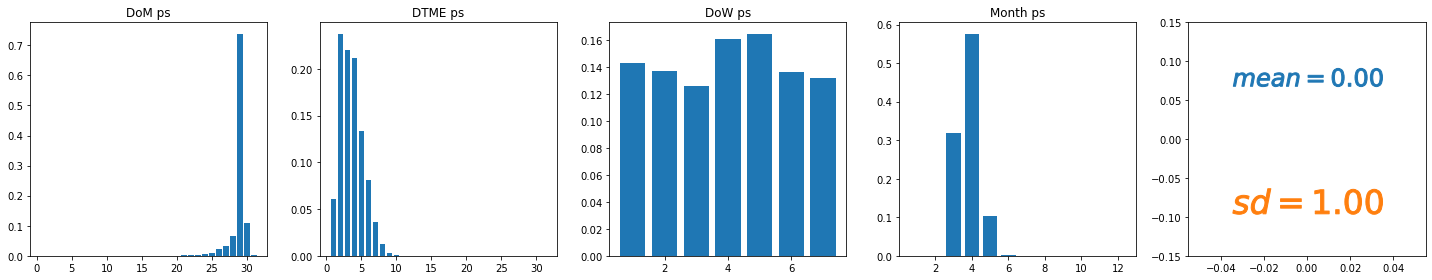

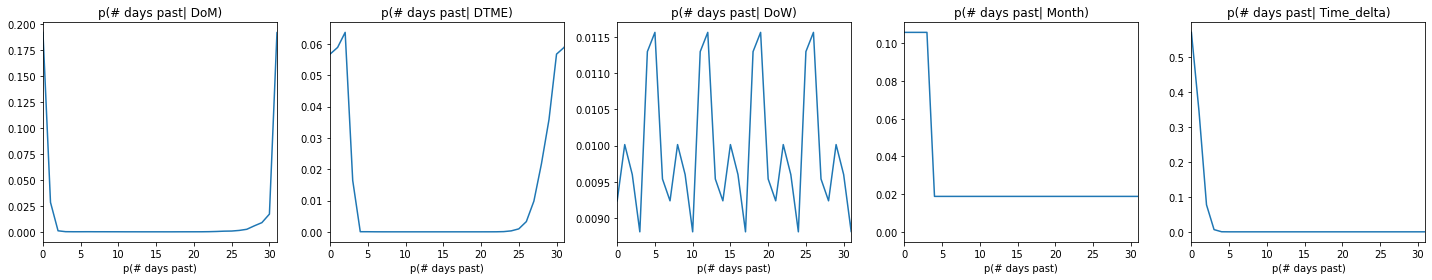

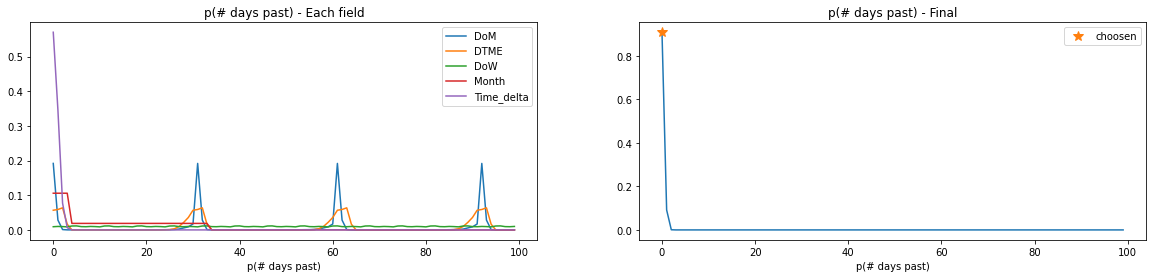





********** Generating element 17 of 20 **********
**Generating k_symbol


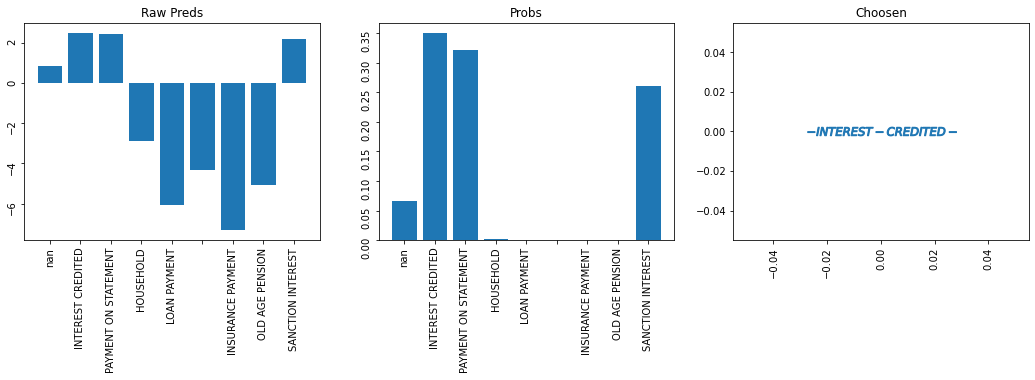

**Generating operation


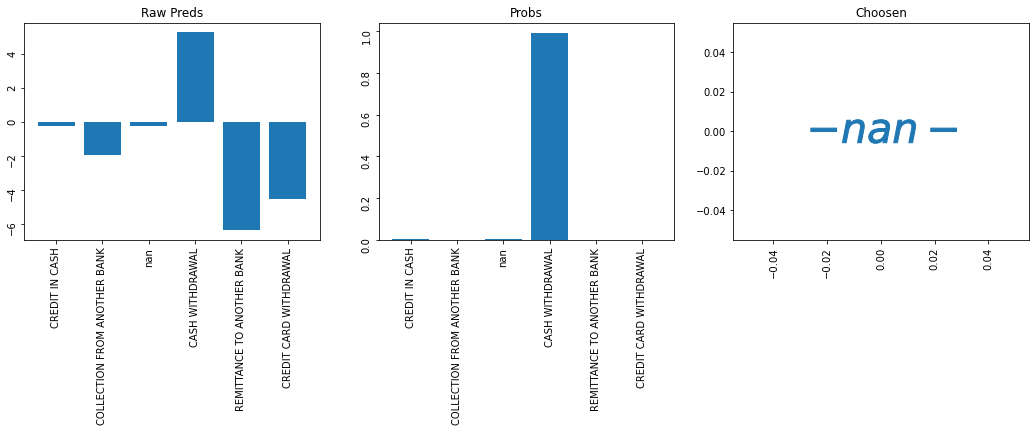

**Generating type


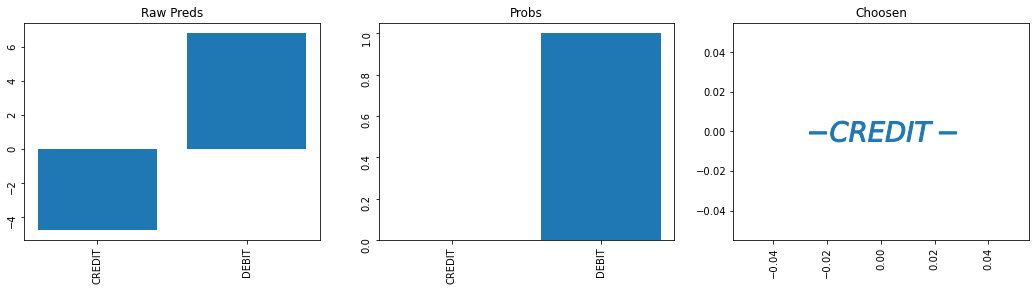

Amount. Unscaled mean = 0.99, sd = 0.00
Sampled value: 1.77
Unscaled value: 74.58



*** Generating next date. Current Date is: 1993-03-28 0




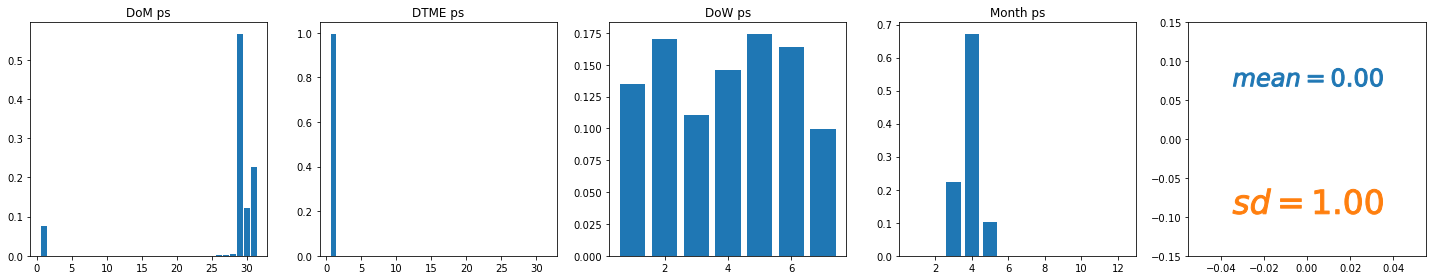

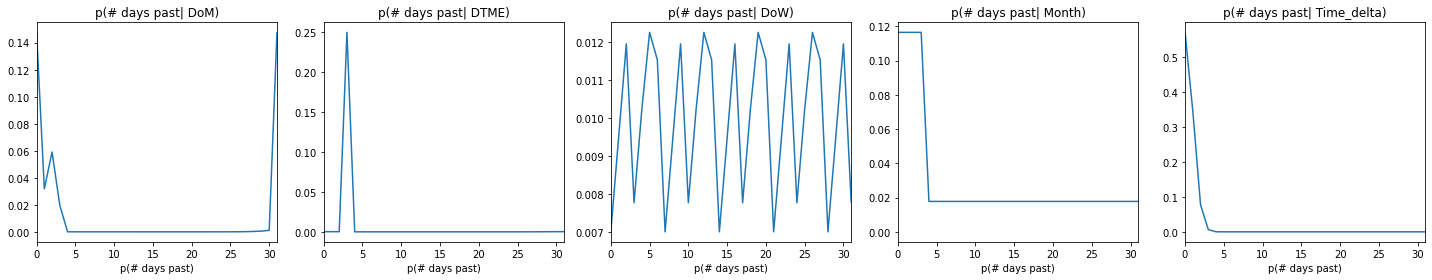

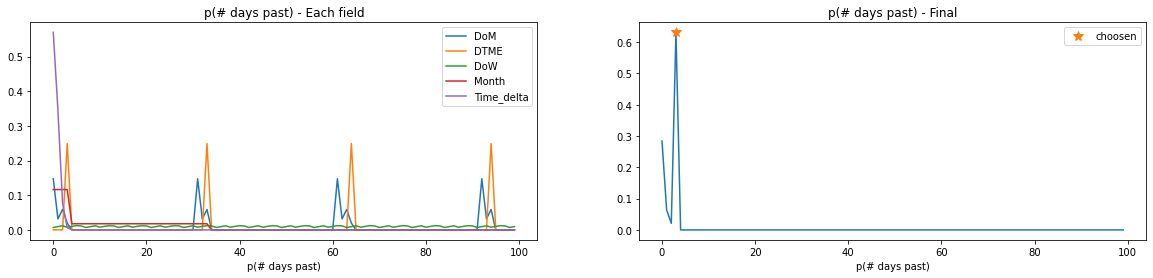





********** Generating element 18 of 20 **********
**Generating k_symbol


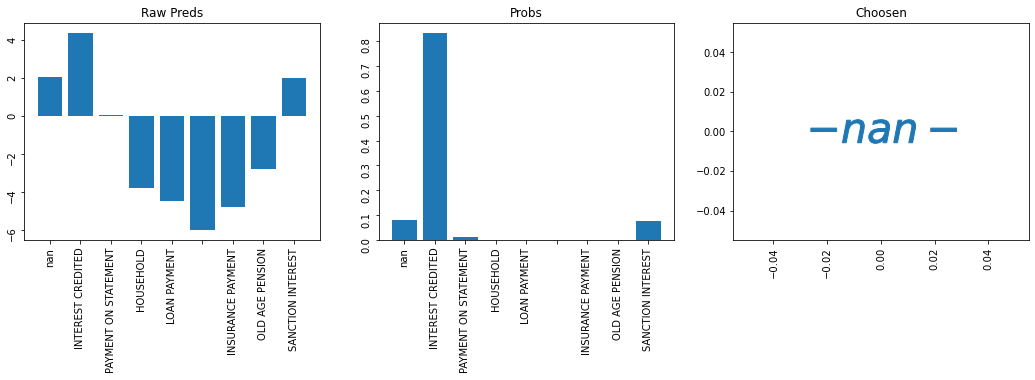

**Generating operation


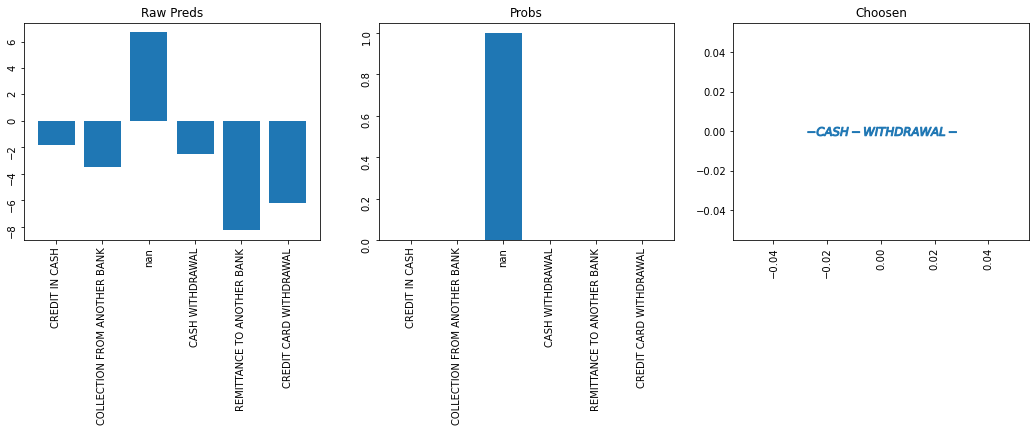

**Generating type


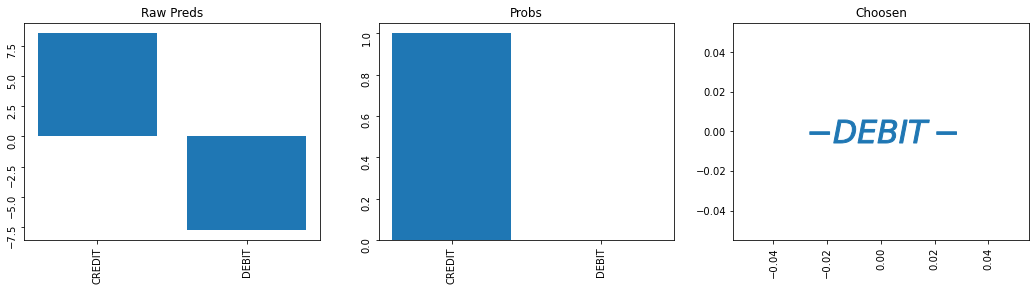

Amount. Unscaled mean = 1.64, sd = 0.00
Sampled value: 0.97
Unscaled value: 9.85



*** Generating next date. Current Date is: 1993-03-31 0




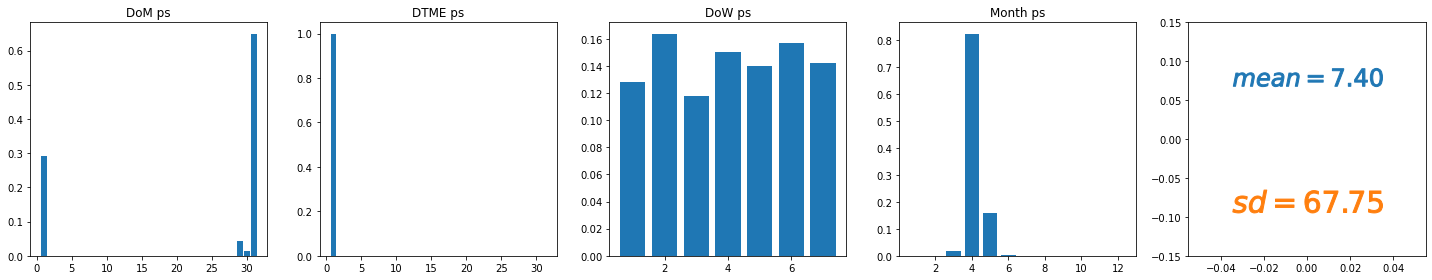

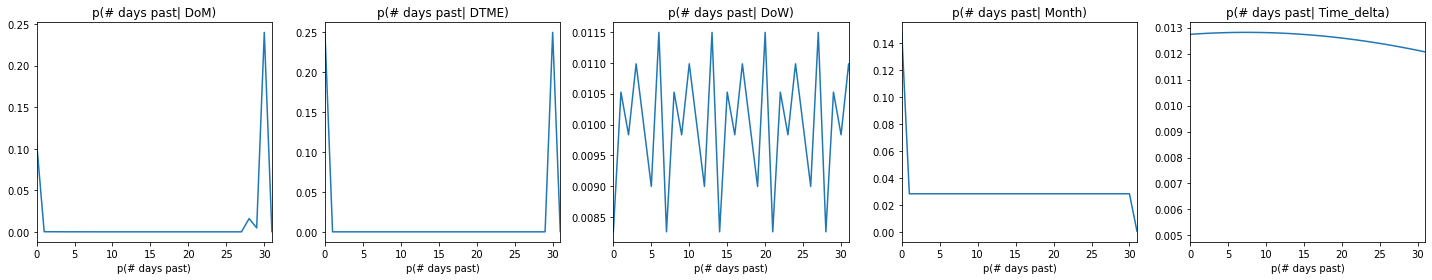

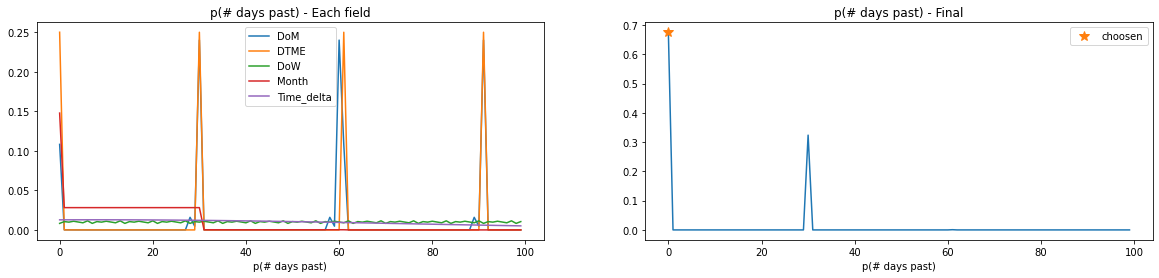





********** Generating element 19 of 20 **********
**Generating k_symbol


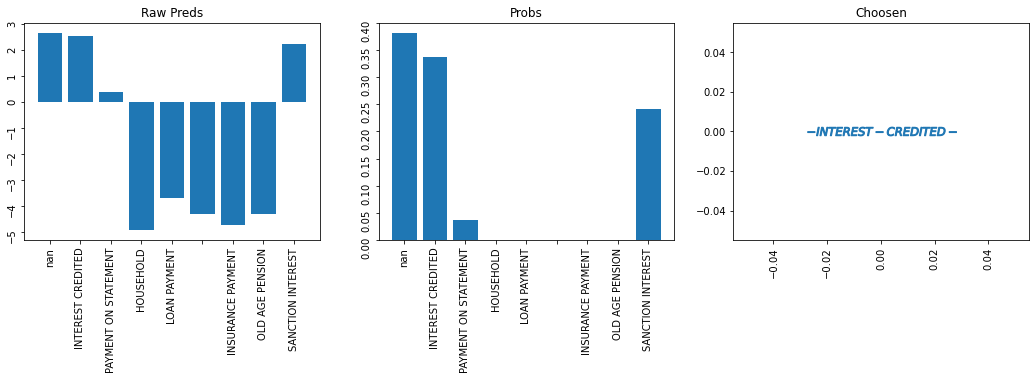

**Generating operation


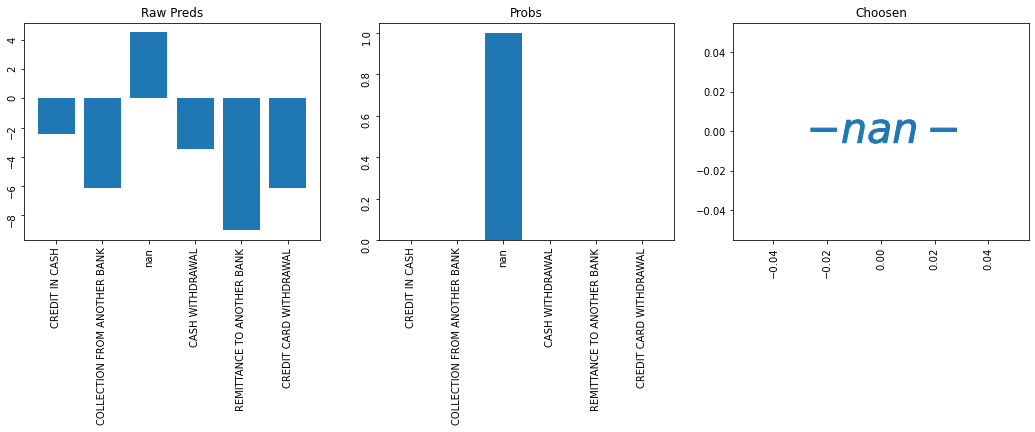

**Generating type


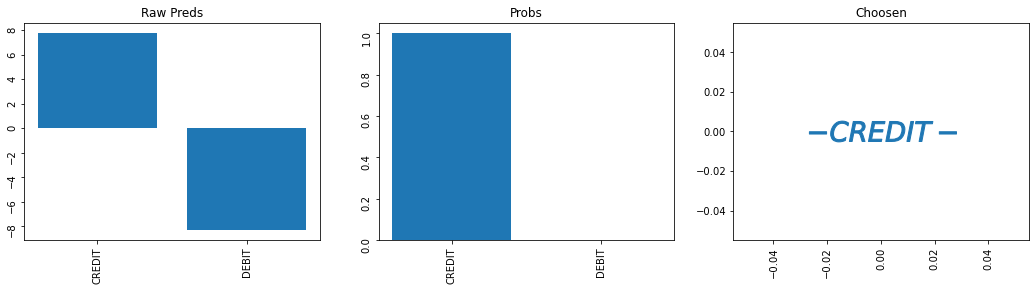

Amount. Unscaled mean = 2.02, sd = 0.00
Sampled value: 2.95
Unscaled value: 1371.92



*** Generating next date. Current Date is: 1993-03-31 0




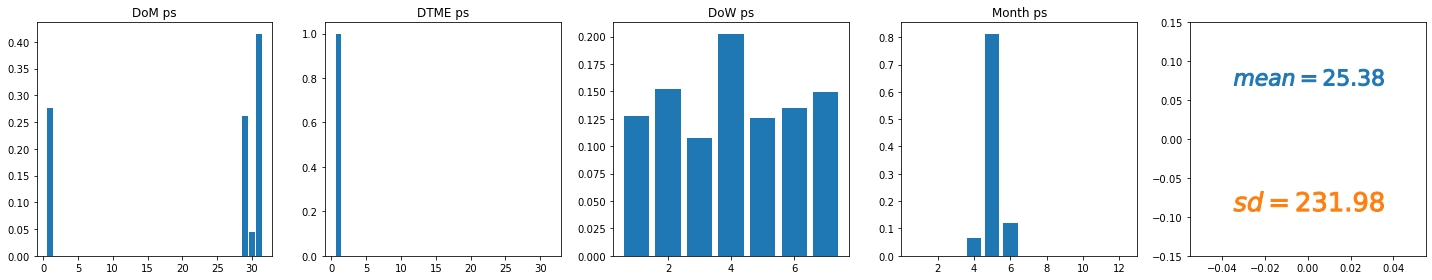

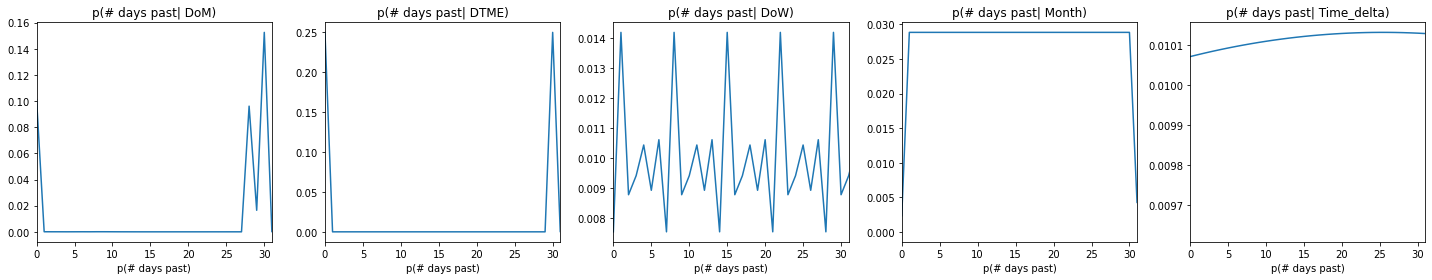

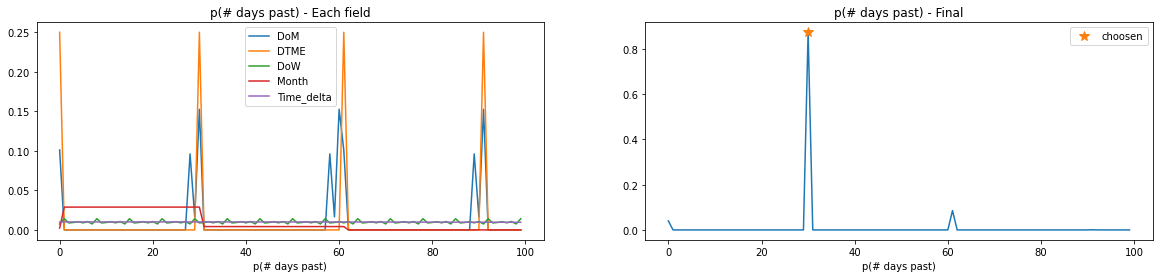





********** Generating element 20 of 20 **********
**Generating k_symbol


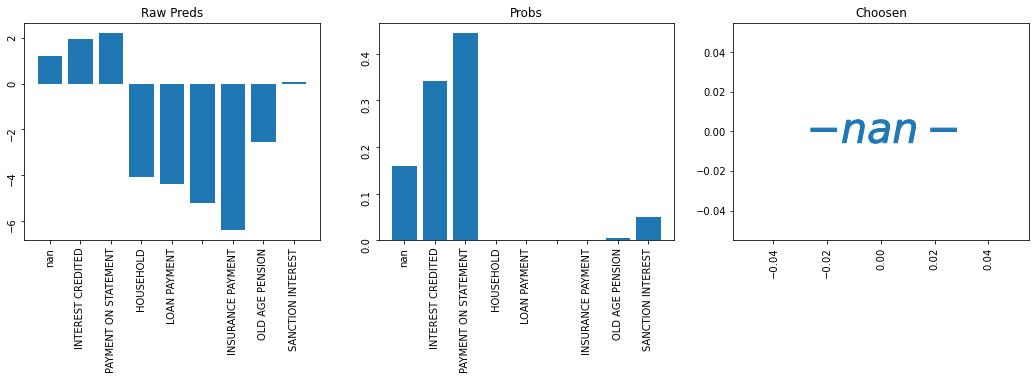

**Generating operation


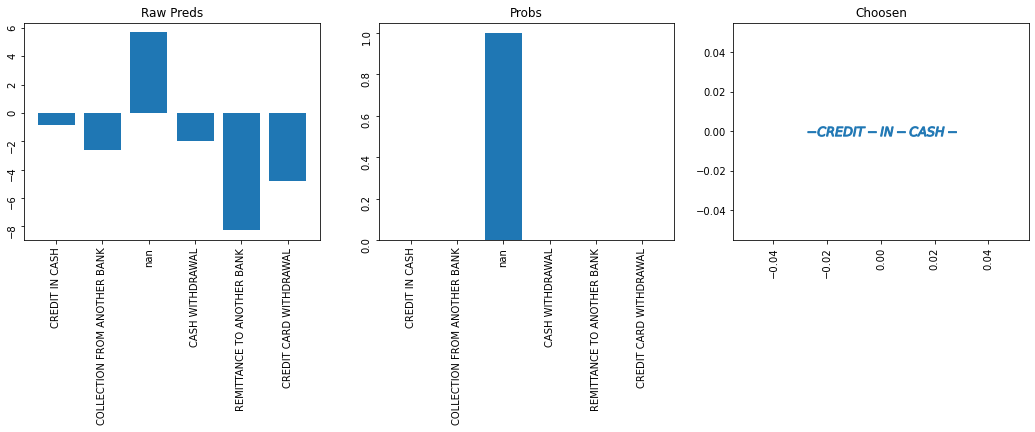

**Generating type


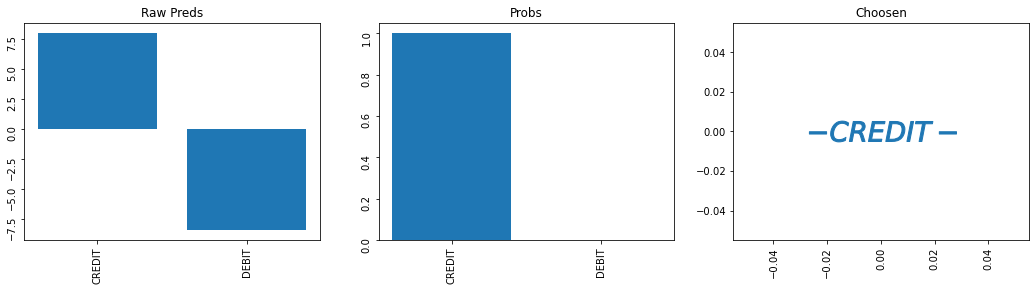

Amount. Unscaled mean = 1.53, sd = 0.00
Sampled value: -0.50
Unscaled value: -0.71



*** Generating next date. Current Date is: 1993-04-30 0




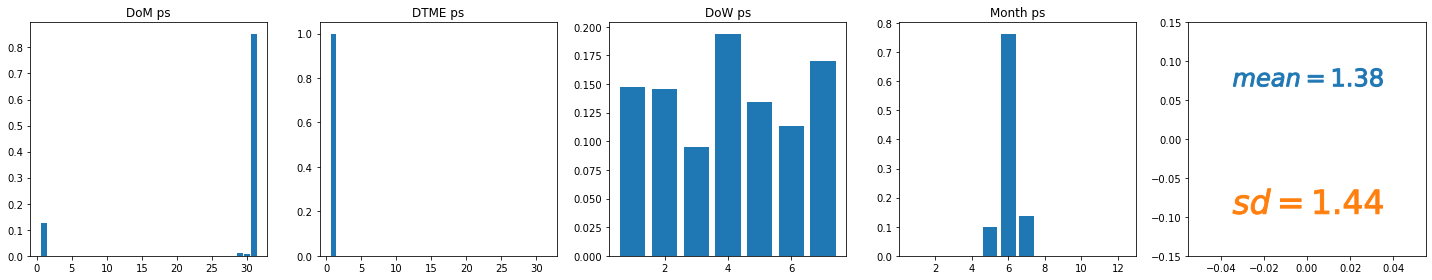

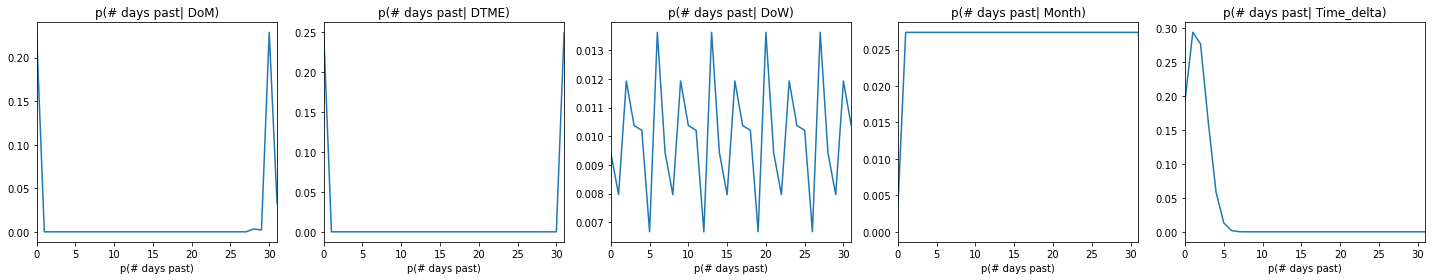

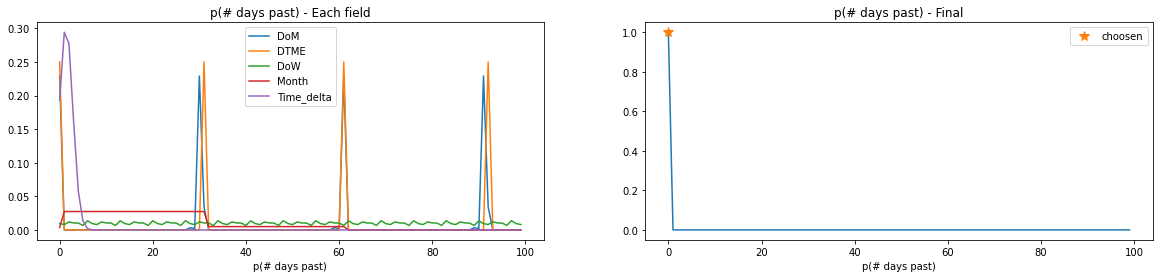

In [92]:
seqs_dfs, seqs, raw = generate_seqs(length= 20, 
                          ages=[75, 25], 
                          start_dates=[START_DATE, START_DATE+datetime.timedelta(days=31)], 
                          greedy_dates=False,
                          return_df_list=True)

In [93]:
df = seqs_dfs[1]
df

amount  k_symbol_num  operation_num  type_num date_fields  \
0      -0.700000             2              3         1       12/01   
1    1741.280029             1              2         0       12/01   
2   48699.980469             0              3         1       12/31   
3     166.460007             1              2         0       12/01   
4     418.910004             1              2         0       12/01   
5     335.529999             0              5         1       12/31   
6   30584.599609             0              0         0       12/31   
7       9.360000             1              2         0       12/01   
8       3.850000             2              3         1       12/01   
9      16.990000             1              2         0       12/01   
10     93.900002             1              2         0       01/01   
11     30.469999             1              2         0       01/01   
12     18.700001             1              2         0       01/01   
13   1079.510010             0              0         0       01/01   
14   2509.310059             1              2         0       01/01   
15  13993.889648             0              0         0       12/01   
16     13.440000             1              2         0       12/01   
17  10246.790039             0              3         1       12/31   
18    781.869995             1              2         0       12/01   
19     19.750000             1              2         0       12/01   

    days_passed  age        date  
0            27   25  1993-02-28  
1             0   25  1993-02-28  
2             5   25  1993-03-05  
3            26   25  1993-03-31  
4            61   25  1993-05-31  
5             6   25  1993-06-06  
6            10   25  1993-06-16  
7            14   25  1993-06-30  
8            31   25  1993-07-31  
9             0   25  1993-07-31  
10           31   25  1993-08-31  
11           61   25  1993-10-31  
12           30   25  1993-11-30  
13           27   25  1993-12-27  
14            4   25  1993-12-31  
15           62   25  1994-03-03  
16           28   25  1994-03-31  
17           11   25  1994-04-11  
18           19   25  1994-04-30  
19           31   25  1994-05-31

In [75]:
type(raw), len(raw)

(list, 26)

In [76]:
[type(x) for x in raw]

[numpy.ndarray,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict,
 dict]

In [77]:
pd.DataFrame([x.keys() for x in raw[1:]])

0              1         2    3      4    5     6      7  \
0   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
1   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
2   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
3   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
4   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
5   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
6   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
7   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
8   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
9   k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
10  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
11  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
12  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
13  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
14  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
15  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
16  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
17  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
18  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
19  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
20  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
21  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
22  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
23  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   
24  k_symbol_num  operation_num  type_num  dow  month  day  dtme  td_sc   

                8  
0   log_amount_sc  
1   log_amount_sc  
2   log_amount_sc  
3   log_amount_sc  
4   log_amount_sc  
5   log_amount_sc  
6   log_amount_sc  
7   log_amount_sc  
8   log_amount_sc  
9   log_amount_sc  
10  log_amount_sc  
11  log_amount_sc  
12  log_amount_sc  
13  log_amount_sc  
14  log_amount_sc  
15  log_amount_sc  
16  log_amount_sc  
17  log_amount_sc  
18  log_amount_sc  
19  log_amount_sc  
20  log_amount_sc  
21  log_amount_sc  
22  log_amount_sc  
23  log_amount_sc  
24  log_amount_sc

In [71]:
raw.keys()

dict_keys(['k_symbol_num', 'operation_num', 'type_num', 'dow', 'month', 'day', 'dtme', 'td_sc', 'log_amount_sc'])

# try copy

In [45]:
enc_preds, raw_ps, date_info = generate_seqs(length= 25, 
                          ages=[75, 25], 
                          start_dates=[START_DATE, START_DATE+datetime.timedelta(days=1)], 
                          greedy_dates=False,
                          return_df_list=True)

In [62]:
raw_ps = raw[2]

In [63]:
(type(raw[3]))

dict

In [67]:
import calendar
get_days_from_end = lambda dt: calendar.monthrange(dt.year, dt.month)[1] - dt.day

In [68]:
start_dates = [START_DATE, START_DATE+datetime.timedelta(days=1)]
date_inds = np.array([(d - START_DATE).days for d in start_dates])
date_inds

PMF_EPS = 1e-6

# Takes raw predictions (info about predicted day, month, dow, and days passed) and start inds 
# (indicate the current date for each of the seqs) 
# Computes a number of days passed for each based on inputs (either greedily or with sampling)
# returns the new_dates (old_dates + days passed) and their indicies
raw = raw_ps
start_inds = date_inds
max_days = 100
greedy_decode=False



# all_ps = [clock_to_onehot(k, raw[k][:,-1]) for k in ["month", "day", "dow"]]
all_ps = [tf.nn.softmax(raw[k][:,-1]).numpy() for k in ["month", "day", "dow"]]

In [78]:
days_till_end

29

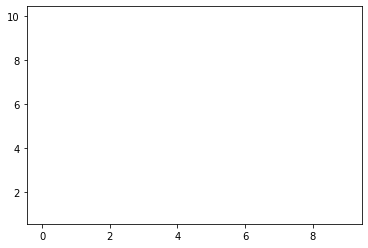

In [79]:
for i in range(10):
    plt.plot(i, i+1)
    
plt.show()

0 (array([3.3676696e-01, 6.5838563e-01, 4.1439855e-03, 2.7425829e-04,
       6.2514653e-07, 8.6237470e-09, 5.0192306e-10, 6.9368143e-11,
       2.0359442e-10, 3.2300156e-09, 4.3040046e-07, 4.2807191e-04],
      dtype=float32), array([0.02459215, 0.01262355, 0.01860988, 0.01364676, 0.02237967,
       0.01217941, 0.03160718, 0.0431139 , 0.05304102, 0.0772751 ,
       0.07121294, 0.08812385, 0.06466848, 0.05416734, 0.02558452,
       0.05687341, 0.03828497, 0.0316718 , 0.0310208 , 0.02092202,
       0.02342946, 0.01991235, 0.0169963 , 0.01768325, 0.01468614,
       0.01448215, 0.01431367, 0.01815323, 0.03173518, 0.01411777,
       0.02289181], dtype=float32), array([0.12718251, 0.13705197, 0.1443757 , 0.12873773, 0.15788533,
       0.18849044, 0.11627627], dtype=float32), array([0., 0.], dtype=float32), 0)
td pred shape (2,)
1993-01-01


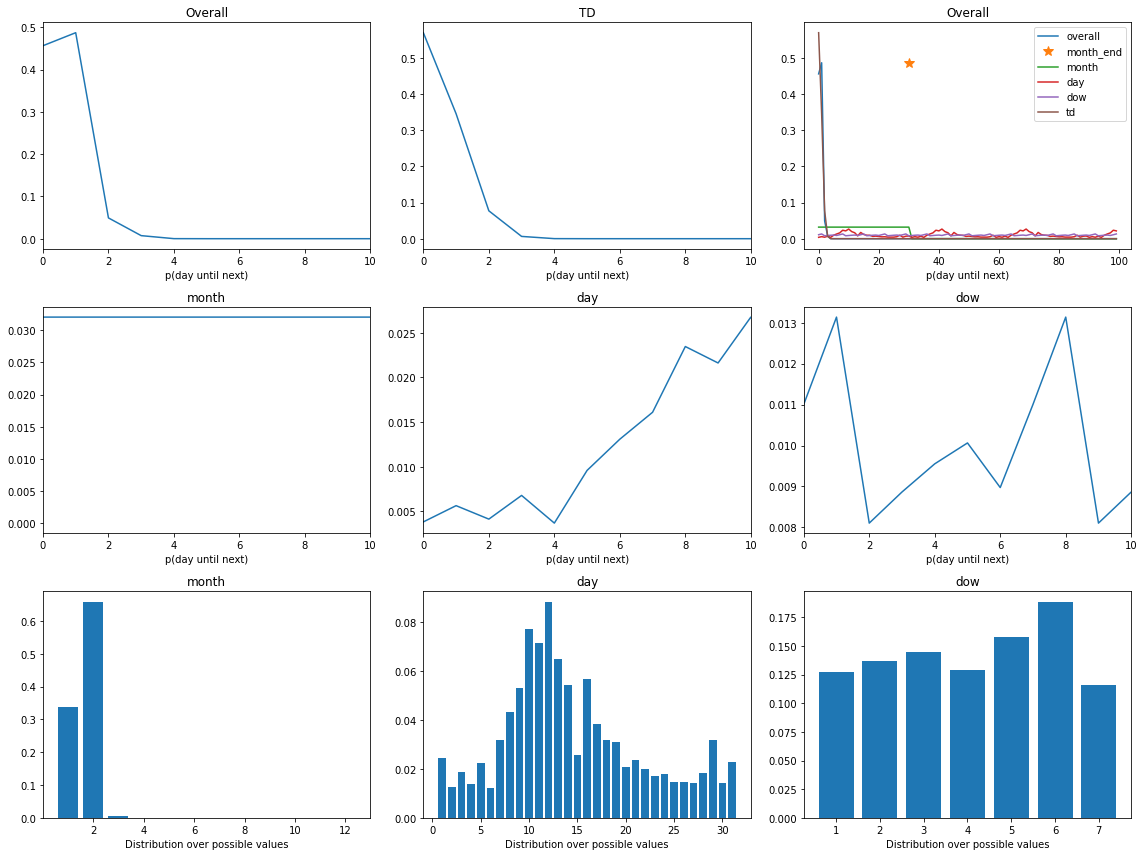

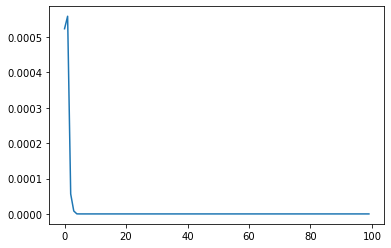

max_days len(ps) 100 100 
 [5.23496333e-004 5.58825258e-004 5.64055725e-005 8.30512854e-006
 1.47077393e-007 4.46672485e-009 2.22030637e-011 5.03650470e-014
 4.84502401e-017 5.60420385e-021 5.67789284e-025 1.23638058e-029
 1.10514529e-034 1.73456211e-040 6.48309349e-046 2.62771849e-052
 2.48805803e-059 1.81935826e-066 3.32026950e-074 3.61820176e-082
 9.31799546e-091 1.21941993e-099 6.96589983e-109 6.03807643e-119
 4.05359208e-129 9.88555605e-140 1.11250894e-150 5.37401098e-162
 3.34242163e-174 2.71350212e-186 2.77434924e-199 5.56465891e-215
 1.84579021e-228 1.09523277e-242 4.52561216e-257 3.13997349e-272
 3.72030932e-287 4.40416751e-303 3.06725834e-319 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+00

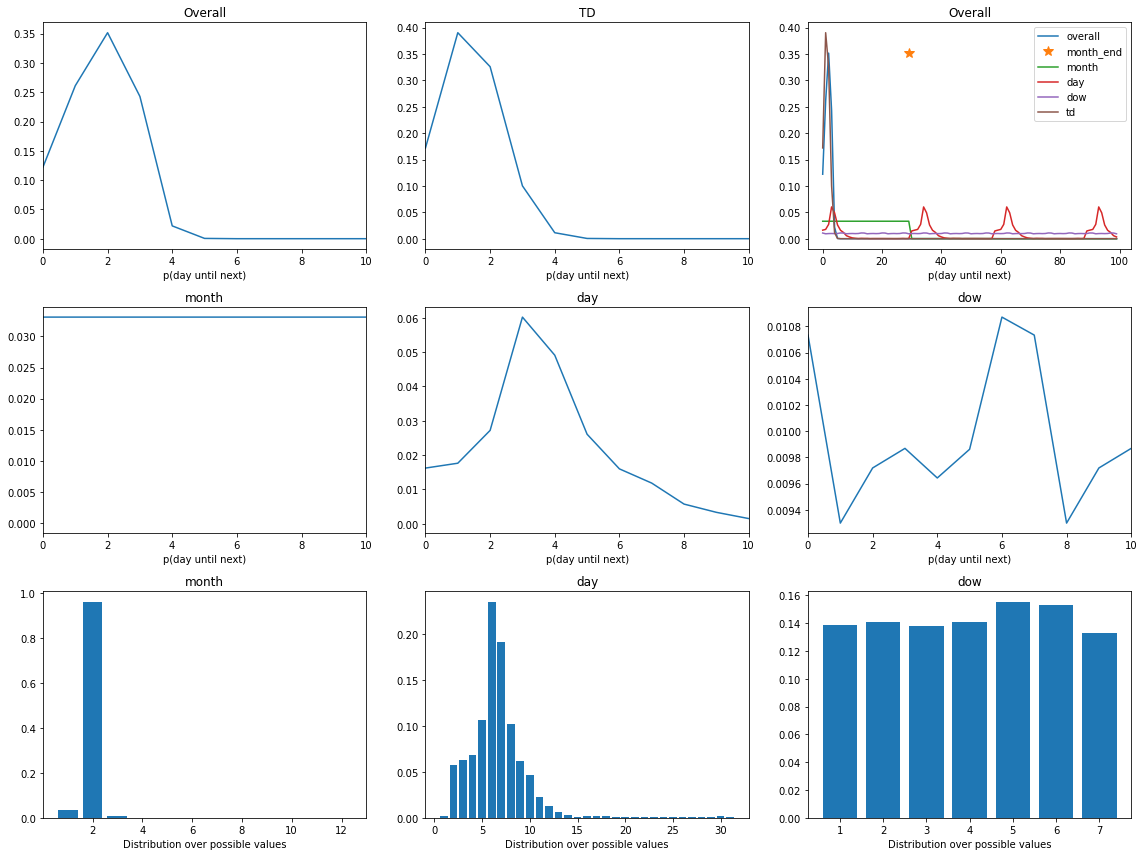

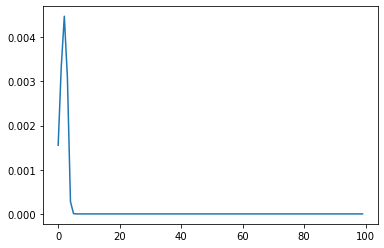

max_days len(ps) 100 100 
 [1.55466308e-003 3.32366469e-003 4.47557027e-003 3.09041549e-003
 2.78291293e-004 6.28370450e-006 6.49096778e-008 2.67019694e-010
 2.31290565e-013 1.06773745e-016 1.37200146e-020 7.46510415e-025
 1.07938240e-029 3.48499732e-034 1.34605398e-039 2.19301505e-045
 5.82013622e-052 2.41017061e-058 2.13818640e-065 7.92750804e-073
 1.19310881e-080 5.01082248e-089 6.44878066e-098 4.00943606e-107
 7.78963937e-117 6.34237799e-127 3.15388948e-137 7.24262285e-148
 1.62228069e-159 3.71197362e-171 5.05289901e-184 1.20191759e-196
 9.97674860e-210 4.52503324e-223 1.16768648e-236 3.65775157e-251
 2.40841139e-266 8.12123739e-282 1.18271243e-297 3.97765597e-314
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+00

In [69]:
timesteps = np.zeros(len(start_inds)).astype(int)

for i, (month_ps, day_ps, dow_ps, td_pred, si) in enumerate(zip(*all_ps, raw["td_sc"][:,-1].numpy(), start_inds)):
    
    print(i, (month_ps, day_ps, dow_ps, td_pred, si))
    print("td pred shape", td_pred.shape)

    sc = data_encoder.TD_SCALE
#     print
    ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] * \
            np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))
#             pmf(max(PMF_EPS, l_pred)*data_encoder.TD_SCALE, AD[si:si+max_days,3]-si ) 




    # days_till_end = get_days_from_end(ALL_DATES[si])
    fig, ax = plt.subplots(3,3, figsize=(16,12))

    ax[0,0].plot(ps/sum(ps))
    # ax[0,0].plot(days_till_end, np.max(ps/sum(ps)), "*", label="month_end", markersize = 10)




    ax[0,0].set_xlim([0, 10])
    ax[0,0].set_title("Overall")

    ax[0,2].plot(ps/sum(ps), label="overall")
    ax[0,2].set_title("Overall")

    # ax[0,2].plot(days_till_end, np.max(ps/sum(ps)), "*", label="month_end", markersize = 10)

    print(ALL_DATES[si])

#             print("max_days", "len(ps)" ,max_days, len(ps), "\n", ps)

    ii = 0
    for lbl, vals in zip(["month", "day", "dow", "td"], [month_ps[AD[si:si+max_days,0]], day_ps[AD[si:si+max_days,1]], dow_ps[AD[si:si+max_days,2]], 
        np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))]):

        if lbl == "td":
            ax[0,1].plot(vals/sum(vals))
            ax[0,1].set_xlim([0, 10])
            ax[0,1].set_title("TD")    
            ax[0,1].plot(days_till_end, np.max(vals/sum(vals)), "*", label="month_end", markersize = 10)
            ax[0,2].plot(vals/sum(vals), label=lbl)


        else:
            ax[0,ii].set_xlabel("p(day until next)")

            ax[1,ii].plot(vals/sum(vals))
            ax[1,ii].set_xlim([0, 10])
            ax[1,ii].set_title(lbl)
            ax[1,ii].set_xlabel("p(day until next)")


            ax[0,2].plot(vals/sum(vals), label=lbl)

            p_vals = eval(f"{lbl}_ps")

            ax[2,ii].bar(np.arange(len(p_vals))+1, p_vals)
#                     ax[2,ii].set_xlim([0, 10])
            ax[2,ii].set_title(lbl)
            ax[2,ii].set_xlabel("Distribution over possible values")


        ii += 1

        
        
    ax[0,2].legend()
    plt.tight_layout()
    plt.show()  

    print("\n\n")

















    if greedy_decode:
        timesteps[i] = np.argmax(ps)
    else:
        plt.plot(ps)
        plt.show()
        print("max_days", "len(ps)" ,max_days, len(ps), "\n", ps)
        timesteps[i] = np.random.choice(max_days, p=ps/sum(ps))


inds = start_inds + timesteps


return_ = tf.expand_dims(
            tf.concat([tf.expand_dims(
                       timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1), 
#                            AD[inds, 4:5]*YEAR_SCALE,
                       bulk_encode_time_value(AD[inds, 0], 12),
                       bulk_encode_time_value(AD[inds, 1], 31),
                       bulk_encode_time_value(AD[inds, 2], 7)
          ], axis=1), axis=1), timesteps

In [ ]:


    days_till_end = get_days_from_end(ALL_DATES[si])
    fig, ax = plt.subplots(3,3, figsize=(16,12))

    ax[0,0].plot(ps/sum(ps))
    ax[0,0].plot(days_till_end, np.max(ps/sum(ps)), "*", label="month_end", markersize = 10)






    ax[0,0].set_xlim([0, 10])
    ax[0,0].set_title("Overall")

    ax[0,2].plot(ps/sum(ps), label="overall")
    ax[0,2].set_title("Overall")

    ax[0,2].plot(days_till_end, np.max(ps/sum(ps)), "*", label="month_end", markersize = 10)

    print(ALL_DATES[si])

#             print("max_days", "len(ps)" ,max_days, len(ps), "\n", ps)

    ii = 0
    for lbl, vals in zip(["month", "day", "dow", "td"], [month_ps[AD[si:si+max_days,0]], day_ps[AD[si:si+max_days,1]], dow_ps[AD[si:si+max_days,2]], 
        np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))]):

        if lbl == "td":
            ax[0,1].plot(vals/sum(vals))
            ax[0,1].set_xlim([0, 10])
            ax[0,1].set_title("TD")    
            ax[0,1].plot(days_till_end, np.max(vals/sum(vals)), "*", label="month_end", markersize = 10)
            ax[0,2].plot(vals/sum(vals), label=lbl)


        else:
            ax[0,ii].set_xlabel("p(day until next)")

            ax[1,ii].plot(vals/sum(vals))
            ax[1,ii].set_xlim([0, 10])
            ax[1,ii].set_title(lbl)
            ax[1,ii].set_xlabel("p(day until next)")


            ax[0,2].plot(vals/sum(vals), label=lbl)

            p_vals = eval(f"{lbl}_ps")

            ax[2,ii].bar(np.arange(len(p_vals))+1, p_vals)
#                     ax[2,ii].set_xlim([0, 10])
            ax[2,ii].set_title(lbl)
            ax[2,ii].set_xlabel("Distribution over possible values")


        ii += 1


In [40]:
from field_config import CAT_FIELDS

In [41]:
CAT_FIELDS

['k_symbol_num', 'operation_num', 'type_num']

In [52]:
field = "k_symbol"
for field in CAT_FIELDS:
    field = field.replace("_num", "")
    df[field] = df[field + "_num"].apply(lambda x: get_code_from_num(data_encoder, field, x))
df

amount  k_symbol_num  operation_num  type_num date_fields  \
0      5.890000             2              3         1       01/01   
1   5878.120117             0              0         0       01/01   
2     16.280001             2              3         1       01/01   
3   4848.290039             0              3         1       01/01   
4   2954.149902             0              3         1       12/01   
5   9279.400391             0              0         0       12/31   
6   5528.200195             0              0         0       12/31   
7     12.360000             2              3         1       12/01   
8   4390.529785             0              3         1       12/01   
9     70.769997             1              2         0       12/01   
10  3854.929932             0              3         1       12/01   
11  5122.649902             0              3         1       12/31   
12  7828.740234             0              0         0       12/31   
13  3094.010010             0              3         1       12/31   
14  3244.260010             0              3         1       12/01   
15    13.410000             2              3         1       12/01   
16    90.320000             1              2         0       12/01   
17  5794.060059             0              3         1       12/01   
18  8080.899902             0              0         0       12/31   
19  4633.430176             0              3         1       12/31   
20  7160.040039             0              0         0       12/31   
21    19.200001             2              3         1       12/01   
22   102.389999             1              2         0       12/01   
23  5040.779785             0              3         1       12/01   
24  4969.109863             0              3         1       12/31   

    days_passed  age        date              k_symbol        operation  \
0            29   25  1993-01-31  PAYMENT ON STATEMENT  CASH WITHDRAWAL   
1             0   25  1993-01-31                   NaN   CREDIT IN CASH   
2             0   25  1993-01-31  PAYMENT ON STATEMENT  CASH WITHDRAWAL   
3             0   25  1993-01-31                   NaN  CASH WITHDRAWAL   
4             2   25  1993-02-02                   NaN  CASH WITHDRAWAL   
5             5   25  1993-02-07                   NaN   CREDIT IN CASH   
6             8   25  1993-02-15                   NaN   CREDIT IN CASH   
7            13   25  1993-02-28  PAYMENT ON STATEMENT  CASH WITHDRAWAL   
8             0   25  1993-02-28                   NaN  CASH WITHDRAWAL   
9             0   25  1993-02-28     INTEREST CREDITED              NaN   
10            3   25  1993-03-03                   NaN  CASH WITHDRAWAL   
11            4   25  1993-03-07                   NaN  CASH WITHDRAWAL   
12            6   25  1993-03-13                   NaN   CREDIT IN CASH   
13            5   25  1993-03-18                   NaN  CASH WITHDRAWAL   
14           11   25  1993-03-29                   NaN  CASH WITHDRAWAL   
15            2   25  1993-03-31  PAYMENT ON STATEMENT  CASH WITHDRAWAL   
16            0   25  1993-03-31     INTEREST CREDITED              NaN   
17            2   25  1993-04-02                   NaN  CASH WITHDRAWAL   
18            7   25  1993-04-09                   NaN   CREDIT IN CASH   
19            3   25  1993-04-12                   NaN  CASH WITHDRAWAL   
20            3   25  1993-04-15                   NaN   CREDIT IN CASH   
21           15   25  1993-04-30  PAYMENT ON STATEMENT  CASH WITHDRAWAL   
22            0   25  1993-04-30     INTEREST CREDITED              NaN   
23            1   25  1993-05-01                   NaN  CASH WITHDRAWAL   
24            7   25  1993-05-08                   NaN  CASH WITHDRAWAL   

      type  
0    DEBIT  
1   CREDIT  
2    DEBIT  
3    DEBIT  
4    DEBIT  
5   CREDIT  
6   CREDIT  
7    DEBIT  
8    DEBIT  
9   CREDIT  
10   DEBIT  
11   DEBIT  
12  CREDIT  
13   DEBIT  
14   DEBIT  
15   DEBIT  
16  CREDIT  
17 